## 0. Подготовительная часть ##

In [38]:
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from scipy.stats import multivariate_normal
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

In [264]:
COUNTRY = 'Russia'
START_DATE = dt.datetime.strptime('2020-03-03','%Y-%m-%d')
COL_LIST = ['date', 'total_cases', 'new_cases']

N_TRAIN = 50
N_SAMPLES = 200

## 1. Подготовка данных ##

In [42]:
df = pd.read_csv('data/owid-covid-data.csv', parse_dates=['date'])

In [43]:
df

iso_code continent     location       date  total_cases  new_cases  \
0           AFG      Asia  Afghanistan 2020-02-24          5.0        5.0   
1           AFG      Asia  Afghanistan 2020-02-25          5.0        0.0   
2           AFG      Asia  Afghanistan 2020-02-26          5.0        0.0   
3           AFG      Asia  Afghanistan 2020-02-27          5.0        0.0   
4           AFG      Asia  Afghanistan 2020-02-28          5.0        0.0   
...         ...       ...          ...        ...          ...        ...   
166549      ZWE    Africa     Zimbabwe 2022-03-02     237503.0      632.0   
166550      ZWE    Africa     Zimbabwe 2022-03-03     237503.0        0.0   
166551      ZWE    Africa     Zimbabwe 2022-03-04     238739.0     1236.0   
166552      ZWE    Africa     Zimbabwe 2022-03-05     239019.0      280.0   
166553      ZWE    Africa     Zimbabwe 2022-03-06     239209.0      190.0   

        new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                      NaN           NaN         NaN                  NaN   
1                      NaN           NaN         NaN                  NaN   
2                      NaN           NaN         NaN                  NaN   
3                      NaN           NaN         NaN                  NaN   
4                      NaN           NaN         NaN                  NaN   
...                    ...           ...         ...                  ...   
166549             416.286        5396.0         1.0                1.143   
166550             362.286        5396.0         0.0                0.857   
166551             467.429        5397.0         1.0                0.714   
166552             459.429        5397.0         0.0                0.571   
166553             486.571        5399.0         2.0                0.857   

        ...  female_smokers  male_smokers  handwashing_facilities  \
0       ...             NaN           NaN                  37.746   
1       ...             NaN           NaN                  37.746   
2       ...             NaN           NaN                  37.746   
3       ...             NaN           NaN                  37.746   
4       ...             NaN           NaN                  37.746   
...     ...             ...           ...                     ...   
166549  ...             1.6          30.7                  36.791   
166550  ...             1.6          30.7                  36.791   
166551  ...             1.6          30.7                  36.791   
166552  ...             1.6          30.7                  36.791   
166553  ...             1.6          30.7                  36.791   

        hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                              0.5            64.83                    0.511   
1                              0.5            64.83                    0.511   
2                              0.5            64.83                    0.511   
3                              0.5            64.83                    0.511   
4                              0.5            64.83                    0.511   
...                            ...              ...                      ...   
166549                         1.7            61.49                    0.571   
166550                         1.7            61.49                    0.571   
166551                         1.7            61.49                    0.571   
166552                         1.7            61.49                    0.571   
166553                         1.7            61.49                    0.571   

        excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                        NaN                          NaN   
1                                        NaN                          NaN   
2                                        NaN                          NaN   
3                                        NaN               

In [46]:
df_russia = df[(df['location'] == COUNTRY) & (df['date'] >= START_DATE)][COL_LIST]
df_russia

date  total_cases  new_cases
123955 2020-03-03          3.0        0.0
123956 2020-03-04          3.0        0.0
123957 2020-03-05          4.0        1.0
123958 2020-03-06         13.0        9.0
123959 2020-03-07         13.0        0.0
...           ...          ...        ...
124684 2022-03-02   16353868.0    96180.0
124685 2022-03-03   16445802.0    91934.0
124686 2022-03-04   16533932.0    88130.0
124687 2022-03-05   16619507.0    85575.0
124688 2022-03-06   16698139.0    78632.0

[734 rows x 3 columns]

In [60]:
df_russia['day'] = (df_russia['date'] - START_DATE).apply(lambda x: x.days)

In [67]:
df_russia['new_cases'] = df_russia['new_cases'].apply(lambda x: max(1, x))

In [68]:
train = df_russia[:N_TRAIN]
test = df_russia[N_TRAIN:]

## 2. Экспоненциальная модель ##

### 2._. Визуализация данных ###

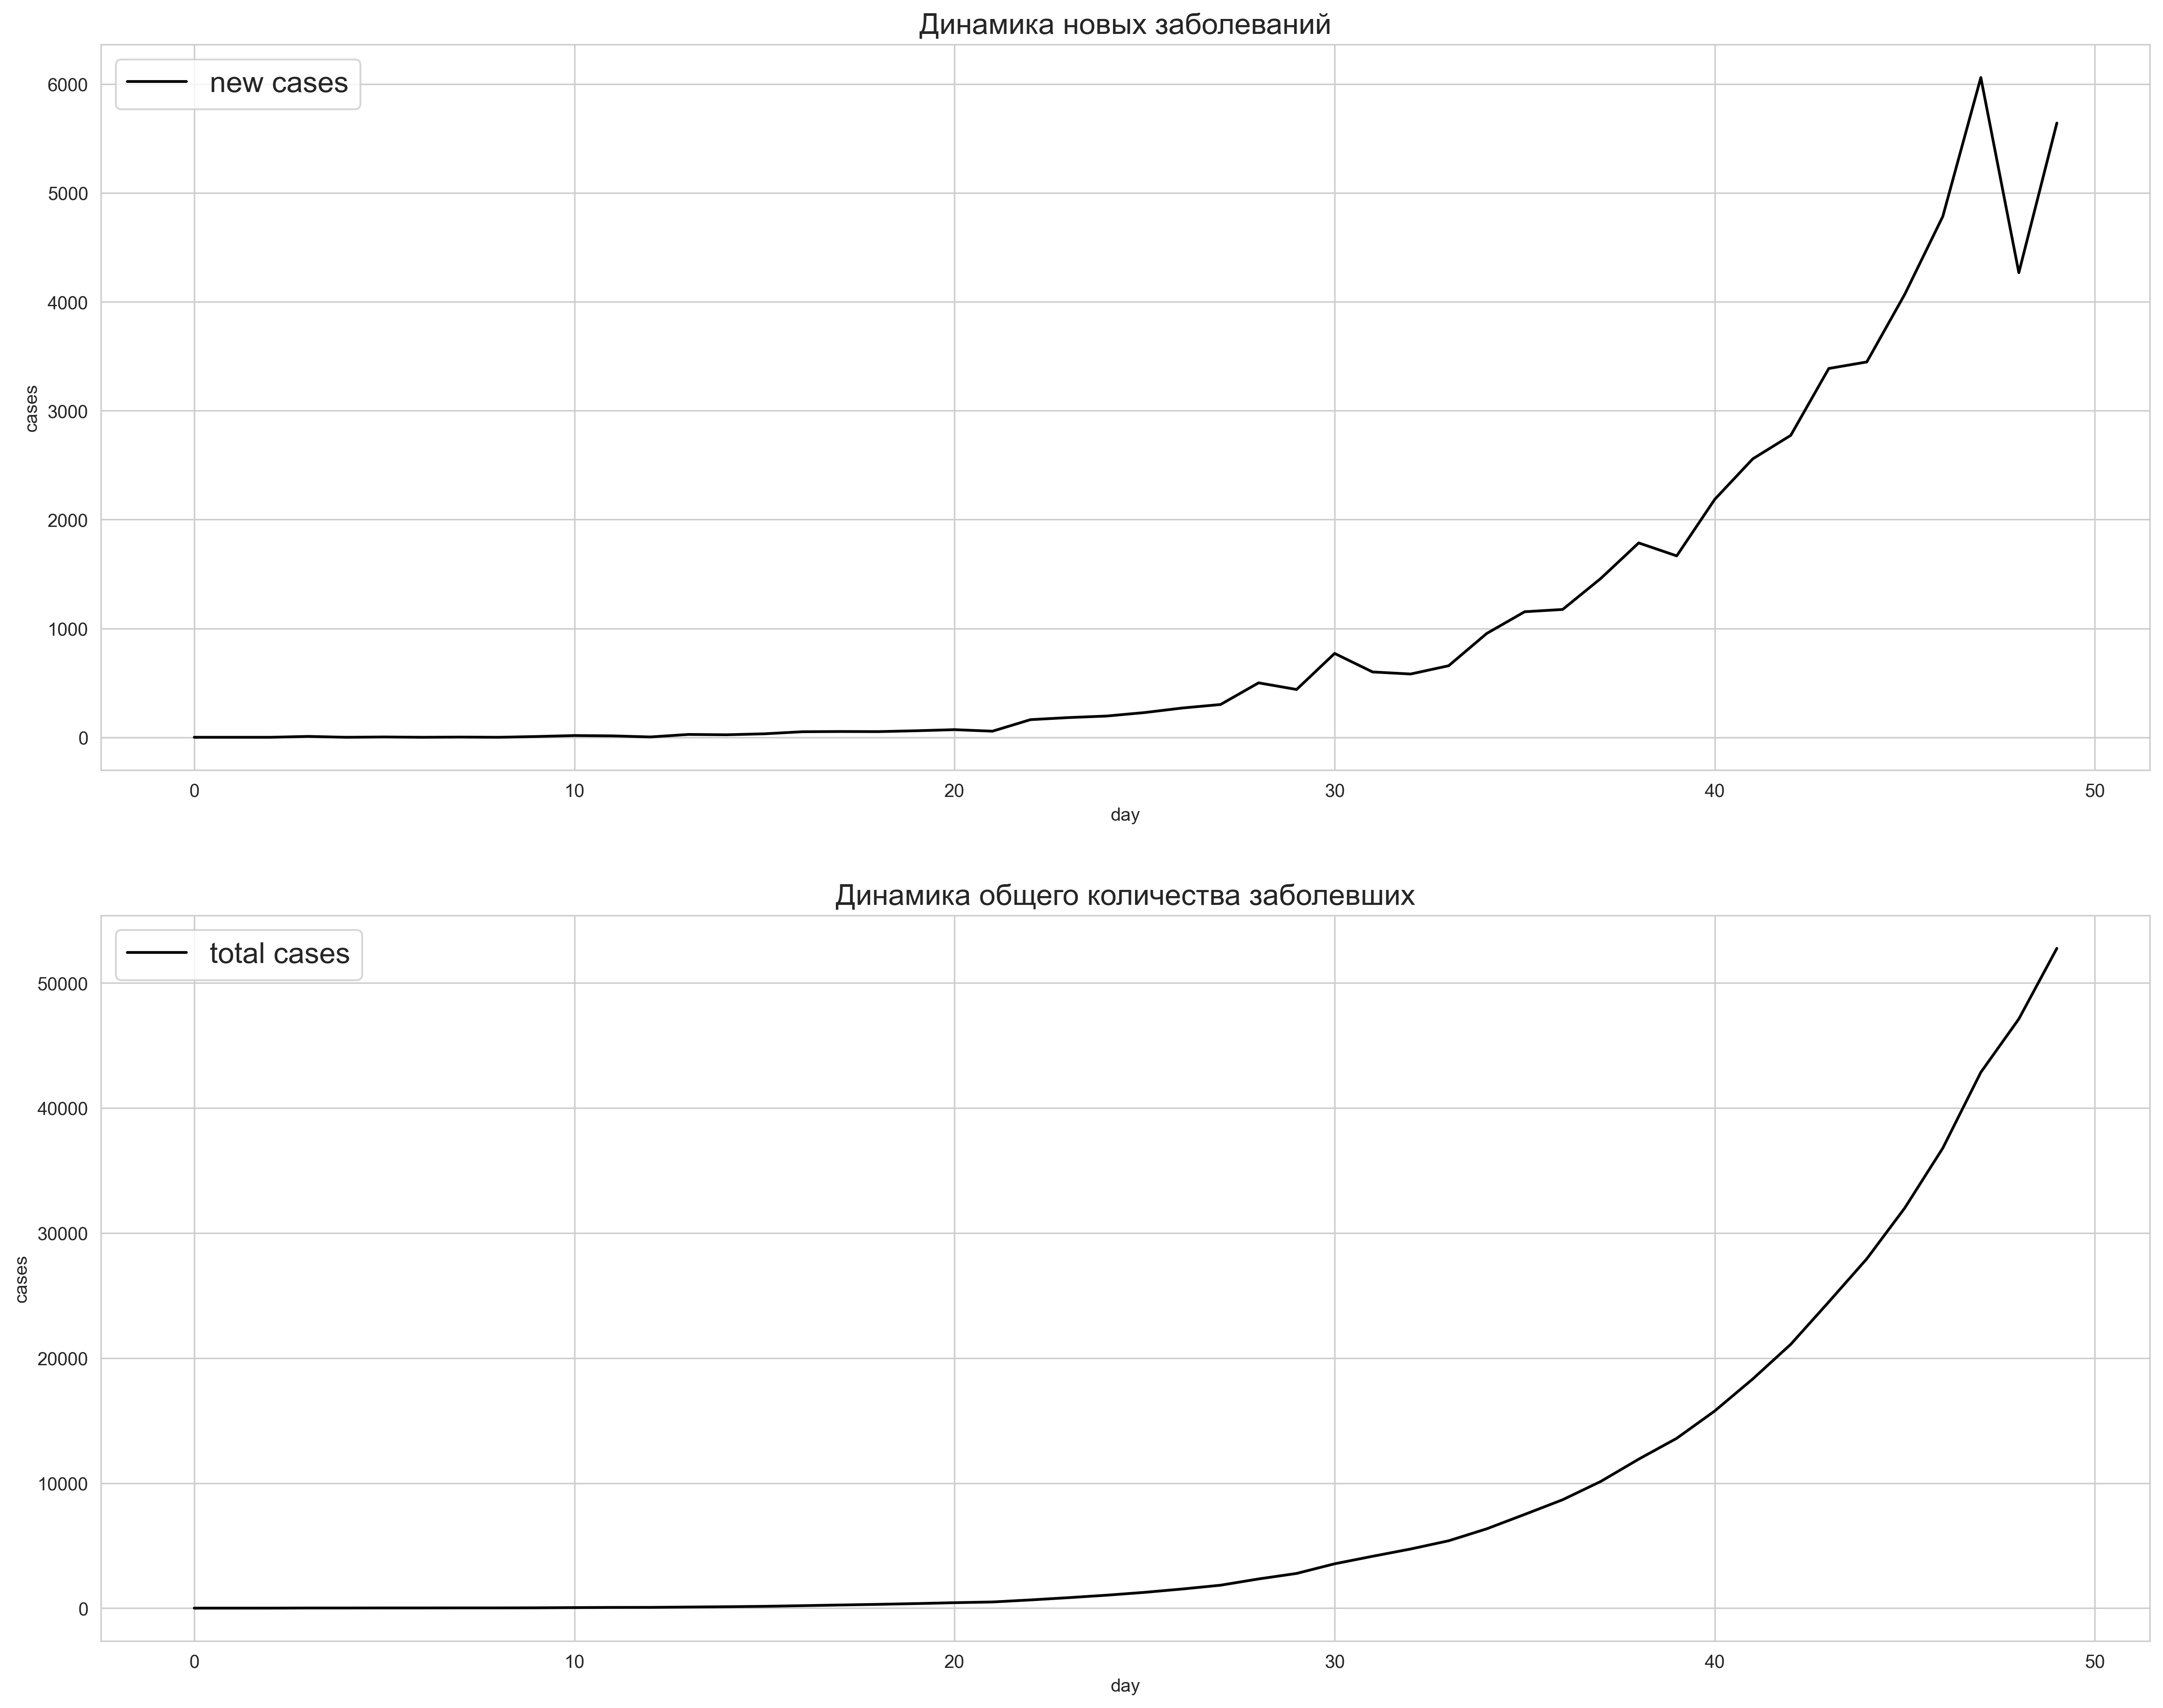

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16))

ax[0].plot(train['day'], train['new_cases'], label='new cases', color='black')
ax[0].set_xlabel('day')
ax[0].set_ylabel('cases')
ax[0].set_title('Динамика новых заболеваний на обучающей выборке', fontsize=16)
ax[0].legend(loc="upper left", fontsize=legend_fontsize)

ax[1].plot(train['day'], train['total_cases'], label='total cases', color='black')
ax[1].set_xlabel('day')
ax[1].set_ylabel('cases')
ax[1].set_title('Динамика общего количества заболевших на обучающей выборке', fontsize=16)
ax[1].legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

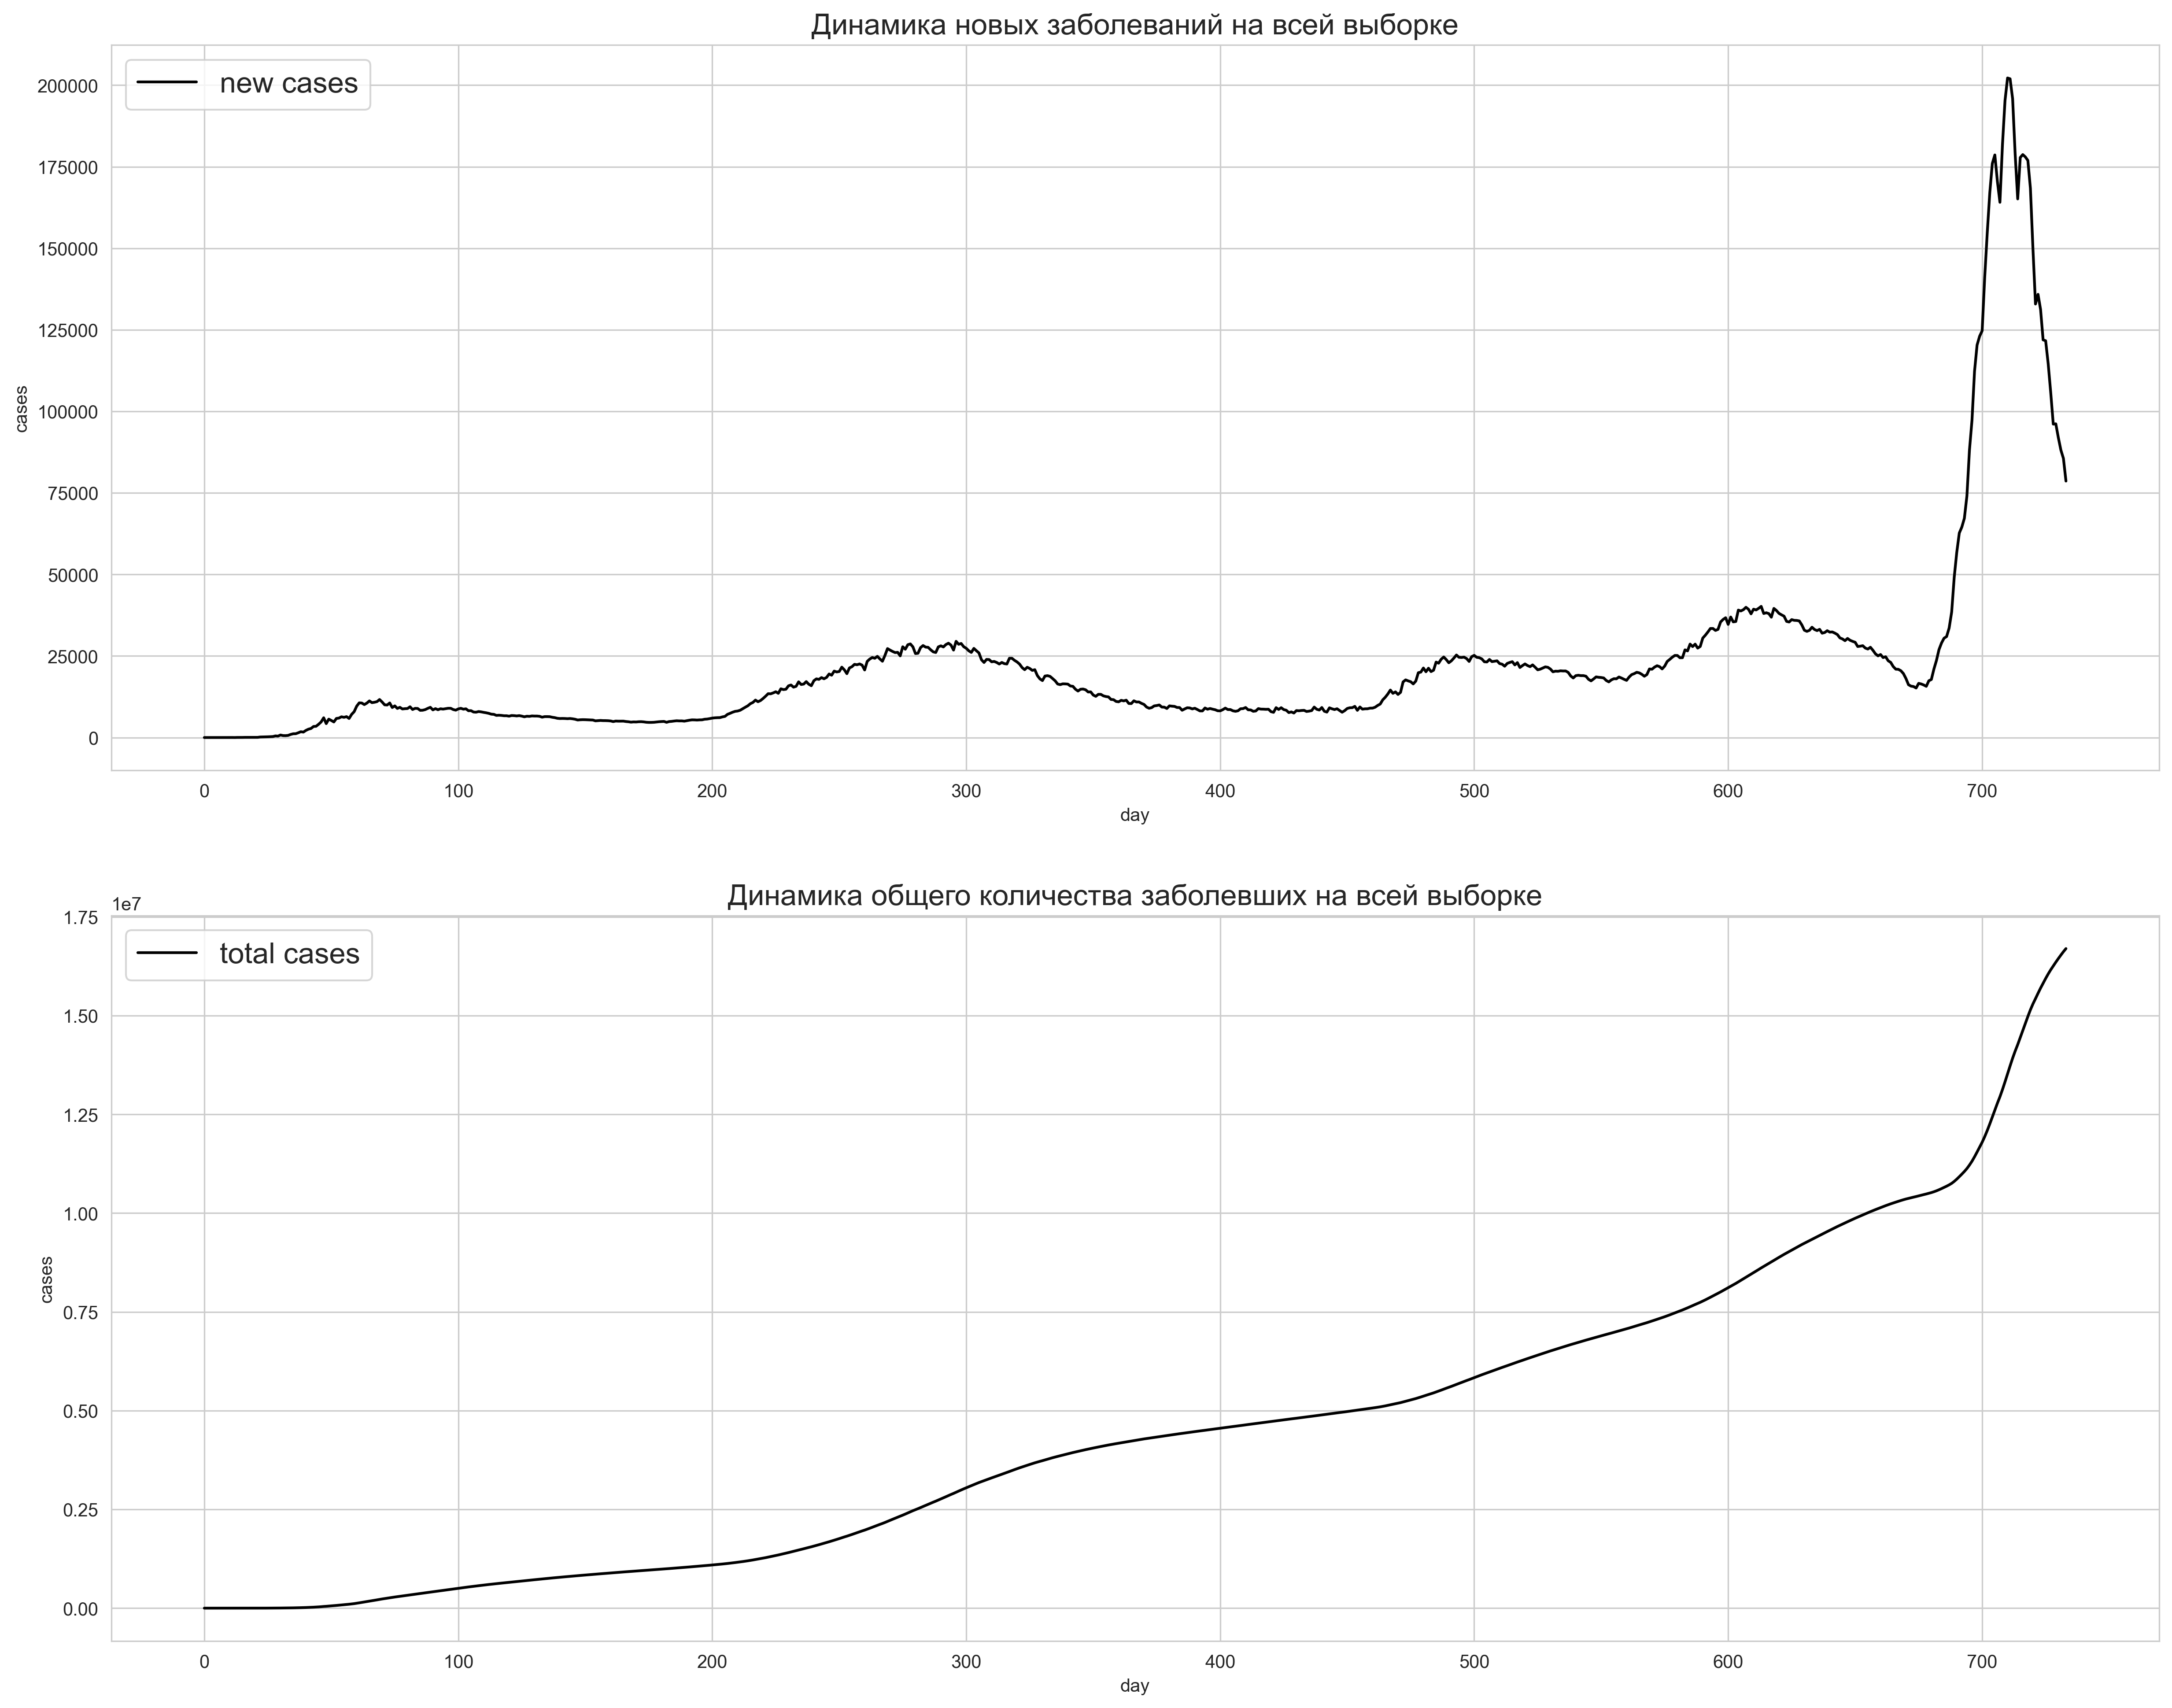

In [87]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16))

ax[0].plot(df_russia['day'], df_russia['new_cases'], label='new cases', color='black')
ax[0].set_xlabel('day')
ax[0].set_ylabel('cases')
ax[0].set_title('Динамика новых заболеваний на всей выборке', fontsize=16)
ax[0].legend(loc="upper left", fontsize=legend_fontsize)

ax[1].plot(df_russia['day'], df_russia['total_cases'], label='total cases', color='black')
ax[1].set_xlabel('day')
ax[1].set_ylabel('cases')
ax[1].set_title('Динамика общего количества заболевших на всей выборке', fontsize=16)
ax[1].legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

### 2.a. Линейная регрессия ###

In [238]:
X_train = np.array(train['day']).reshape(-1,1)
y_train = np.array(np.log(train['total_cases']))

lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.score(X_train, y_train), lr_model.coef_[0], lr_model.intercept_

(0.985339421227631, 0.19829091233588558, 1.8207371487846977)

In [96]:
predicted_train = lr_model.predict(X_train)

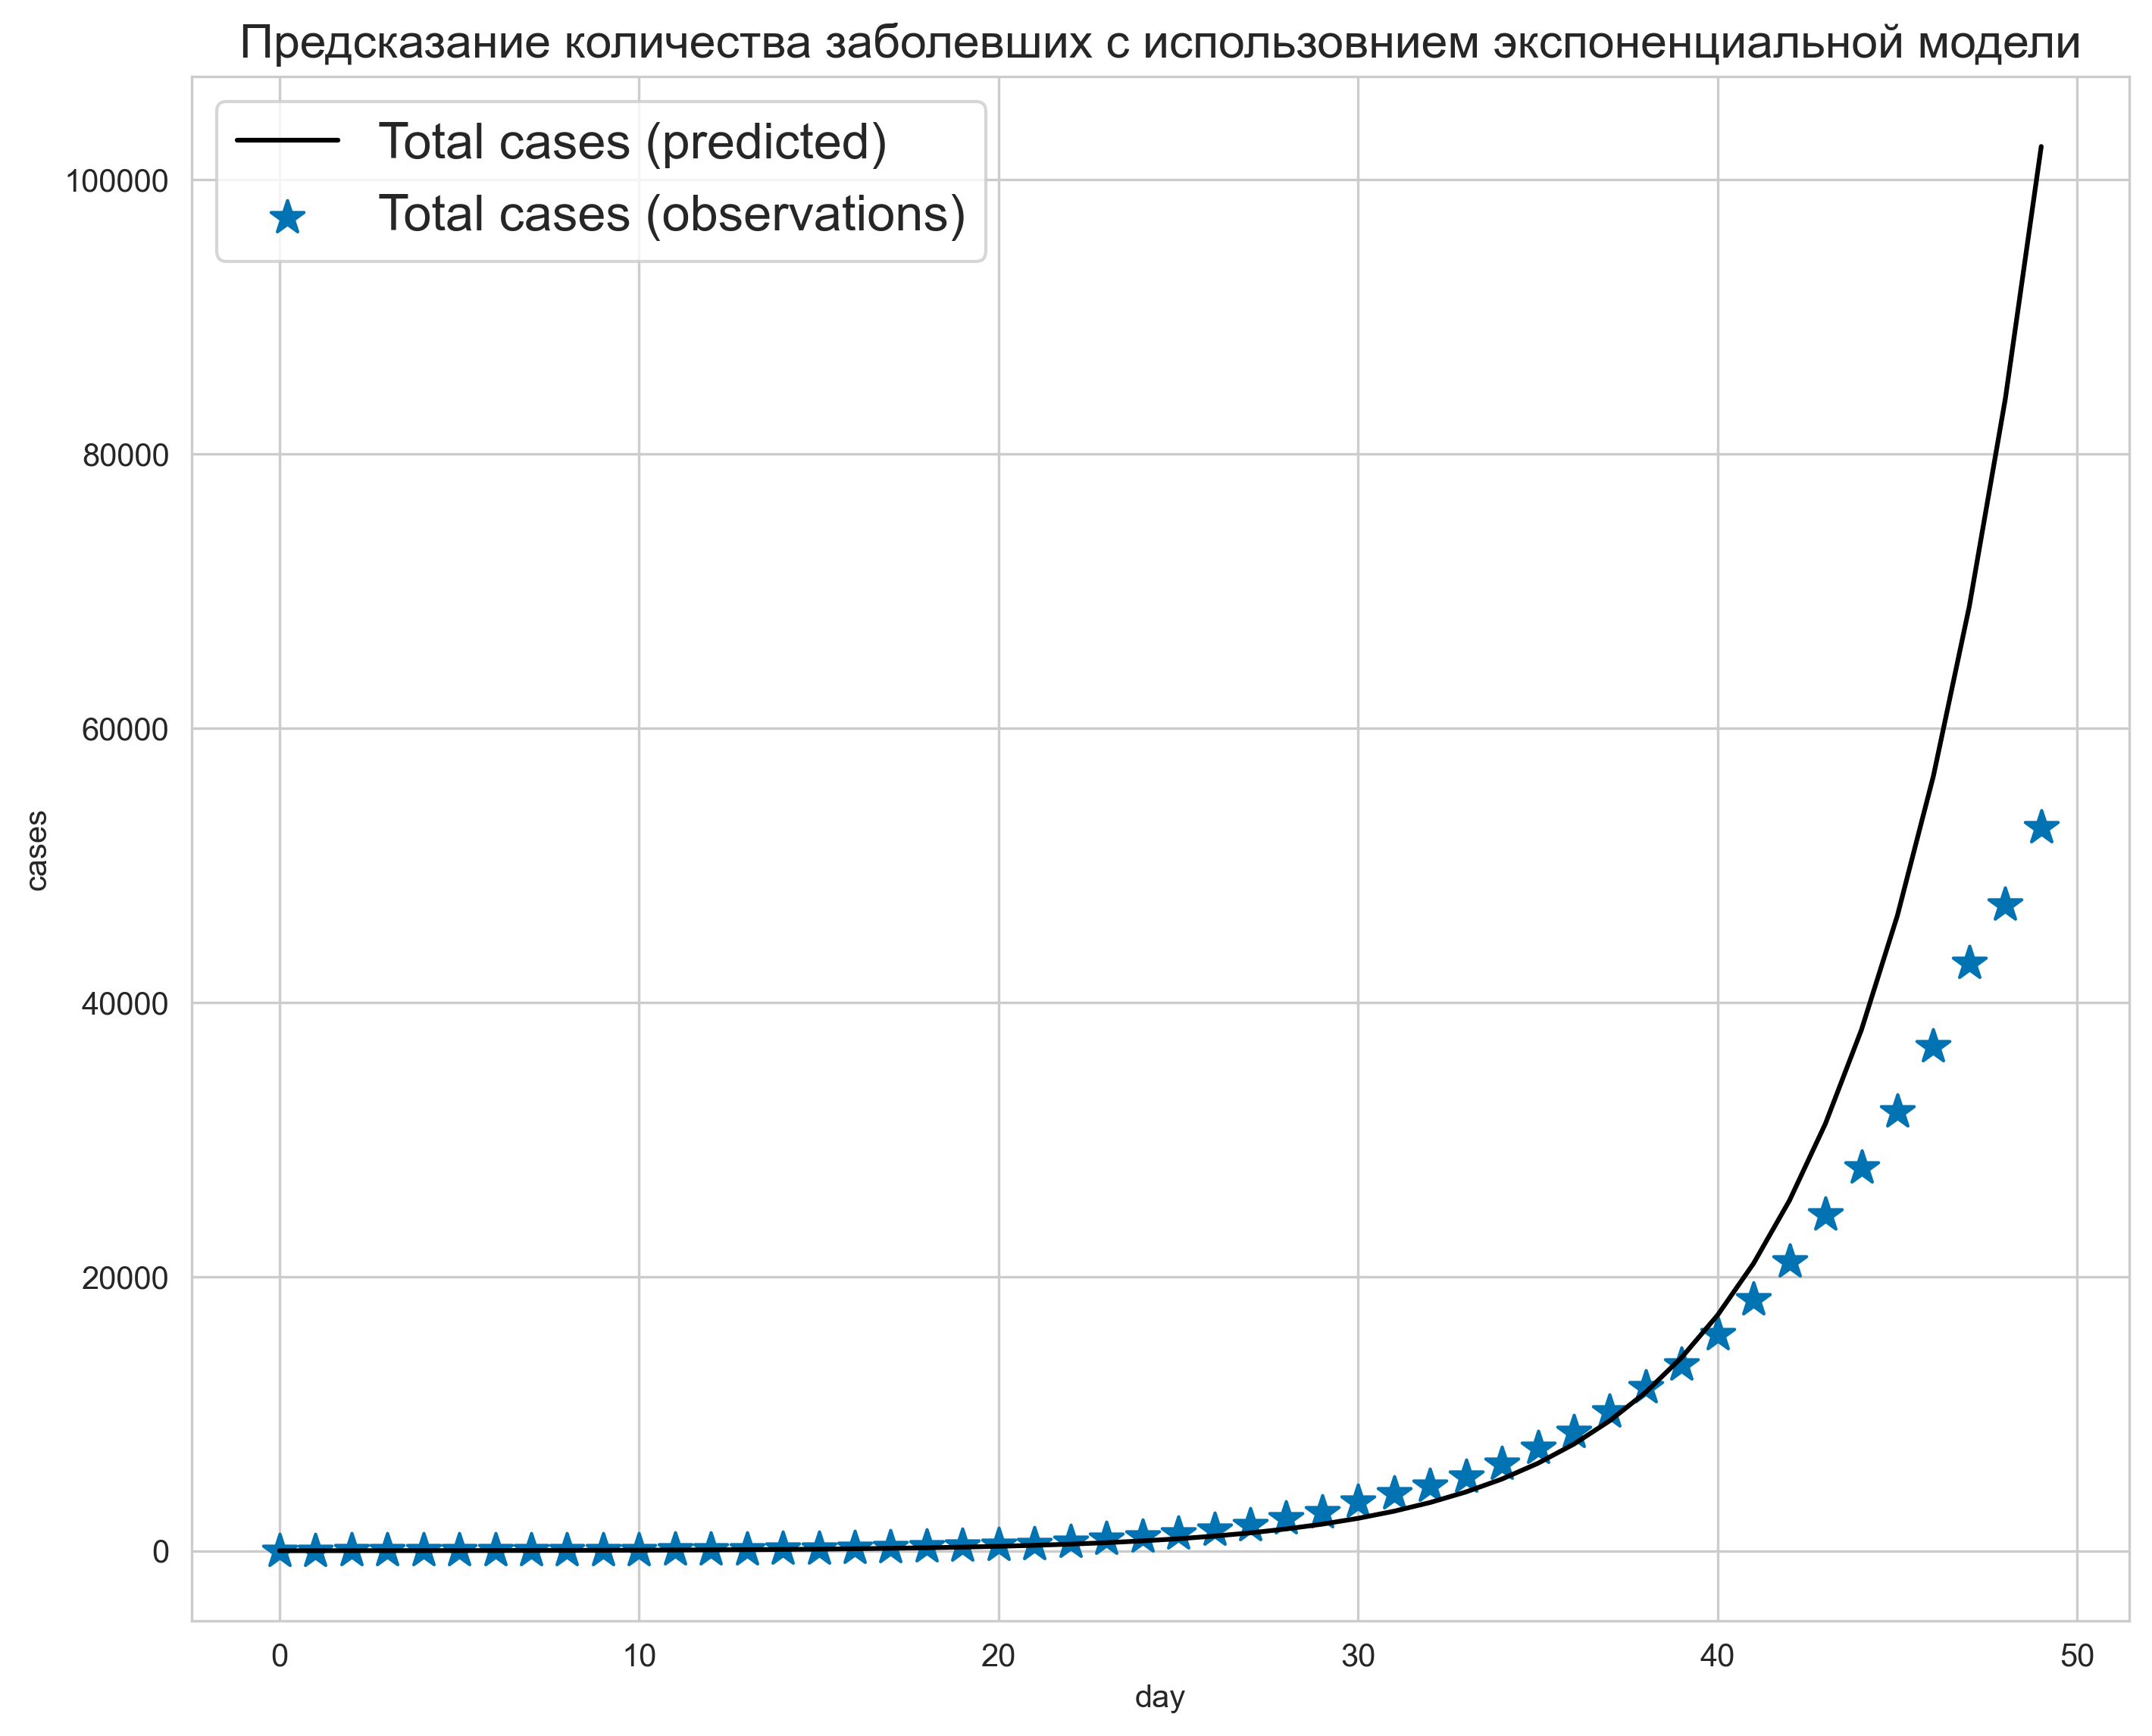

In [99]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.scatter(train['day'], train['total_cases'], label='Total cases (observations)', marker='*', s=120)
ax.plot(train['day'], np.exp(predicted_train), label='Total cases (predicted)', color='black')
ax.set_ylabel('cases')
ax.set_xlabel('day')
ax.set_title('Предсказание количества заболевших с использовнием экспоненциальной модели', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

In [102]:
X_test = np.array(test['day']).reshape(-1,1)
predicred_test = lr_model.predict(X_test)

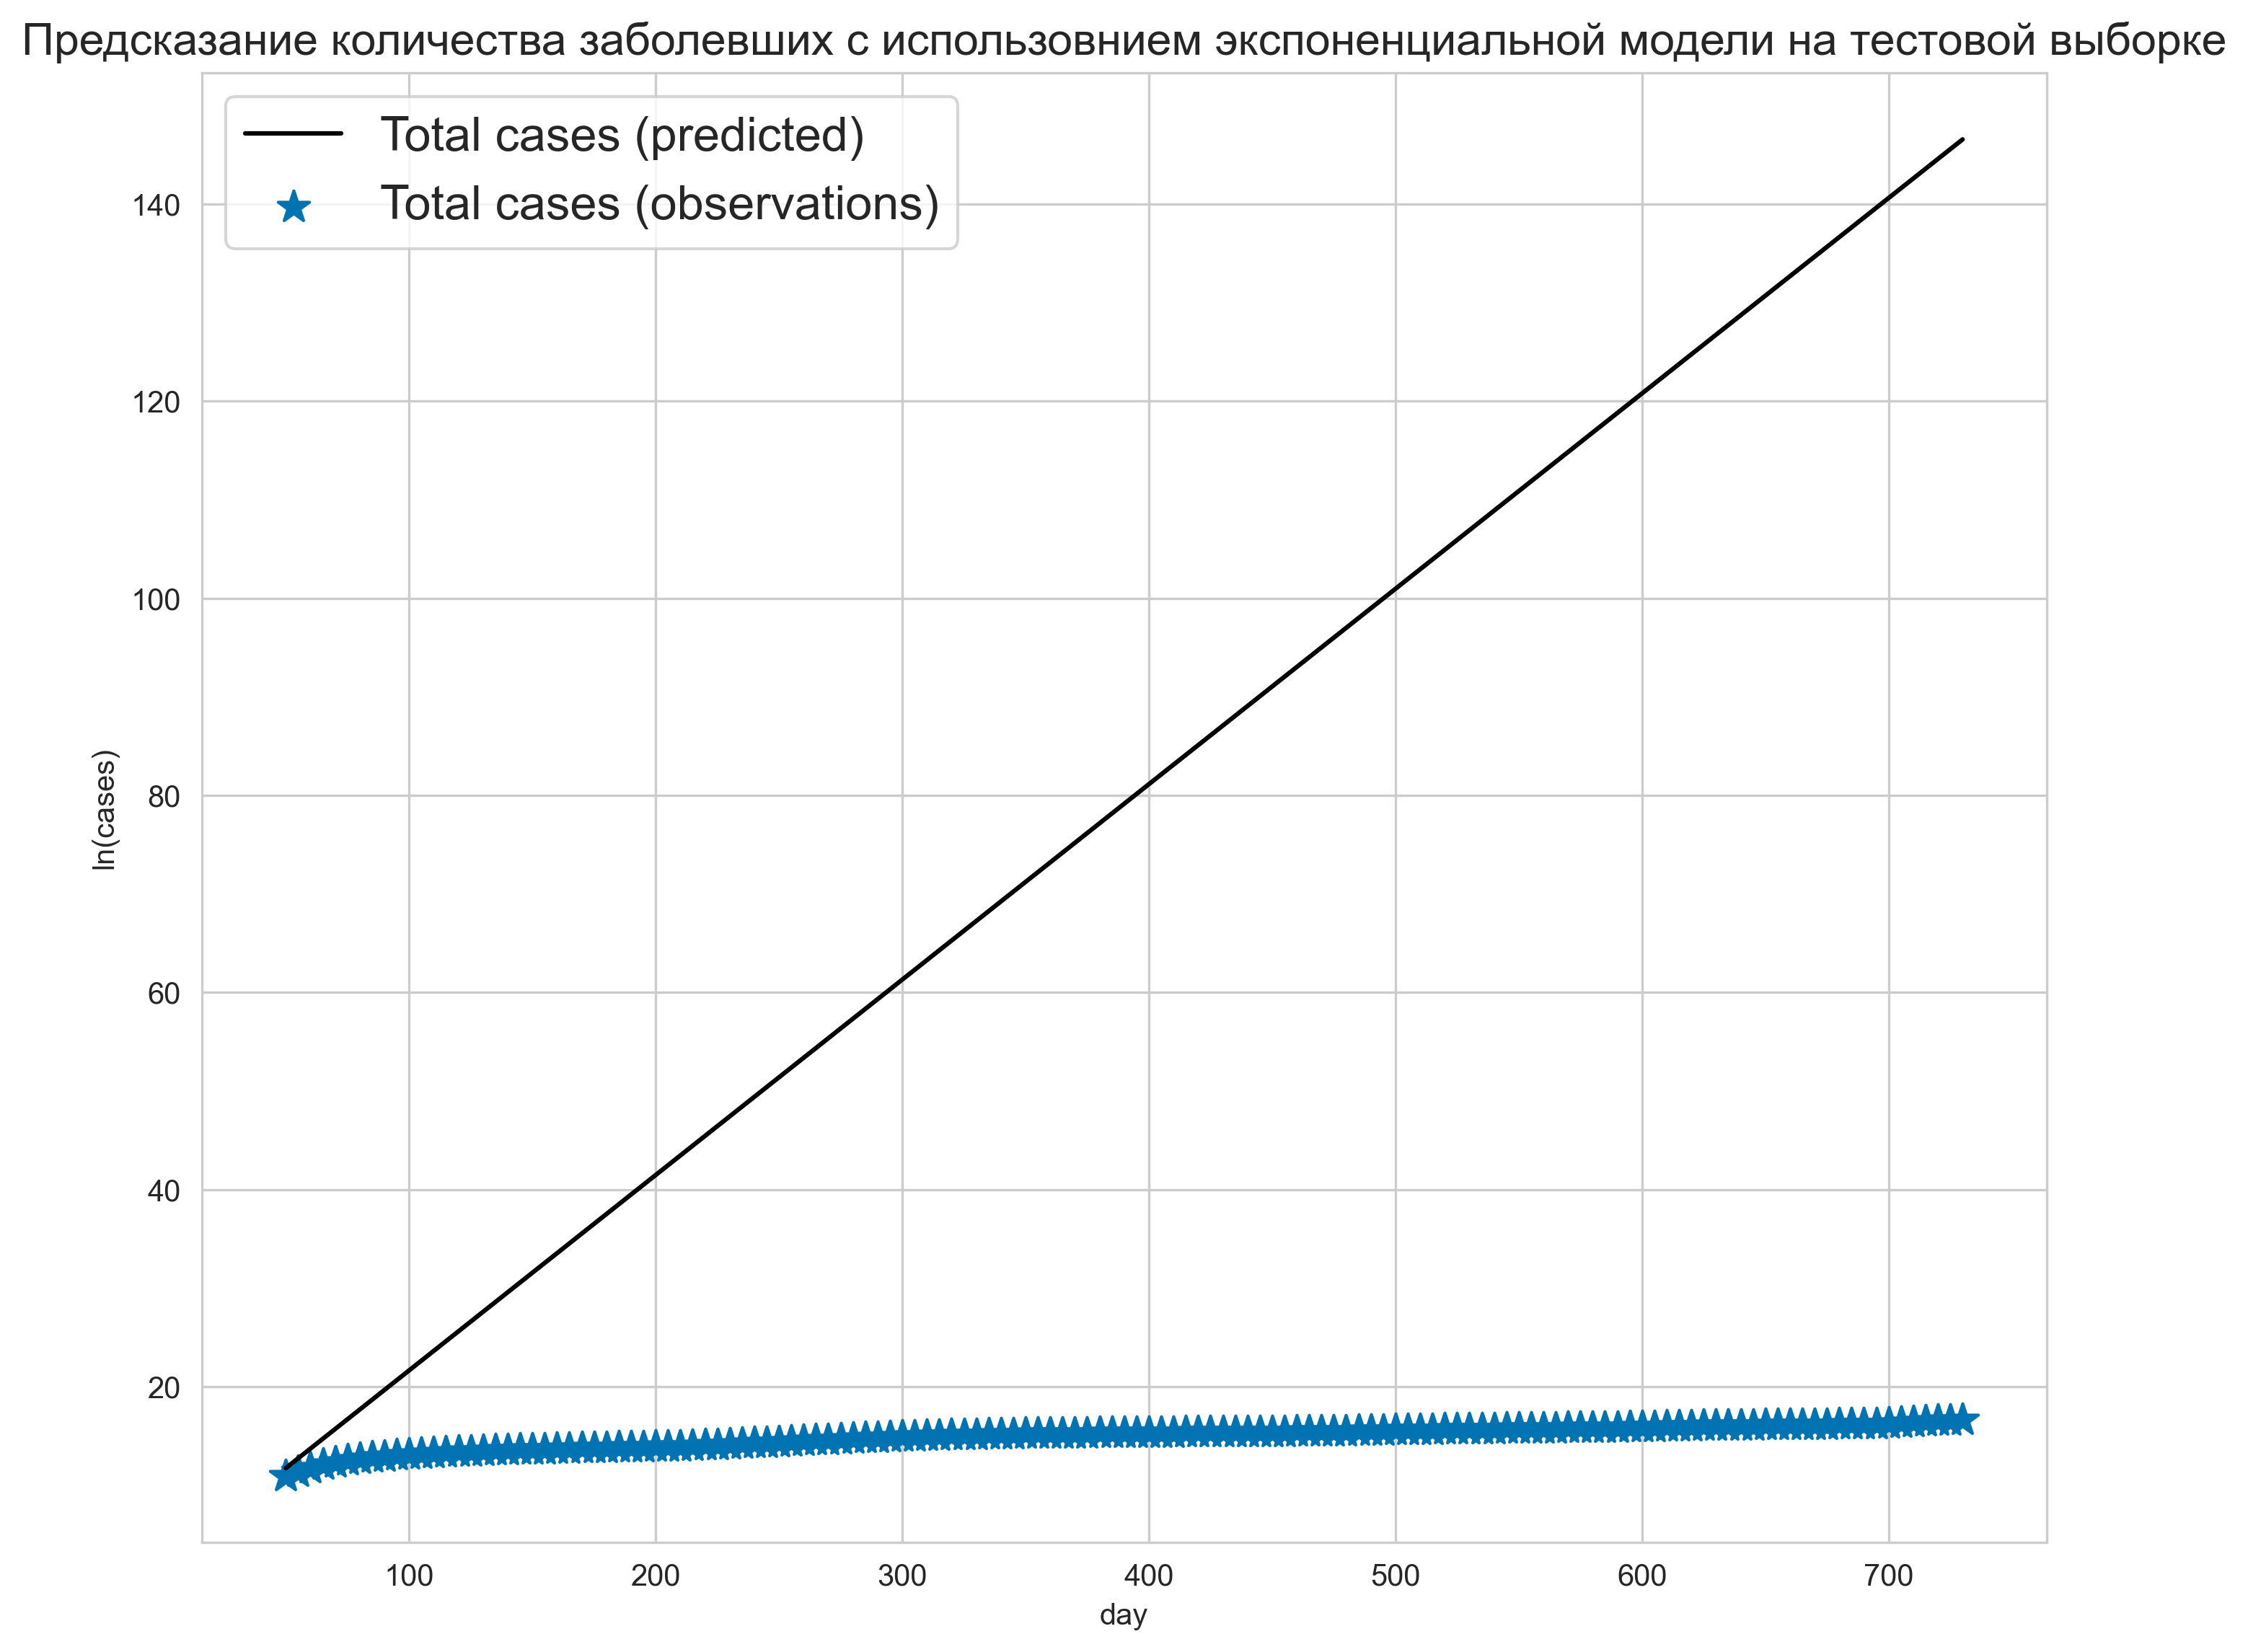

In [104]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.scatter(test['day'][::5], np.log(test['total_cases'])[::5], label='Total cases (observations)', marker='*', s=120)
ax.plot(test['day'][::5], predicred_test[::5], label='Total cases (predicted)', color='black')
ax.set_ylabel('ln(cases)')
ax.set_xlabel('day')
ax.set_title('Предсказание количества заболевших с использовнием экспоненциальной модели на тестовой выборке', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

### 2.b. Апостериорное распределение ###

In [210]:
N = 2000

#xs = np.linspace(-3, 3, N)
XX = np.linspace(-3, 3, N)
YY = np.linspace(-3, 3, N)
XX, YY = np.meshgrid(XX, YY)

pos = np.empty(XX.shape + (2,))
pos[:, :, 0] = XX
pos[:, :, 1] = YY

true_w0, true_w1 = lr_model.coef_[0], lr_model.intercept_
def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((np.min(XX), np.max(XX)))
    plt.ylim((np.min(YY), np.max(YY)))
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.jet)
    plt.scatter(true_w0, true_w1, marker='*', s=120)

(2000, 2000)


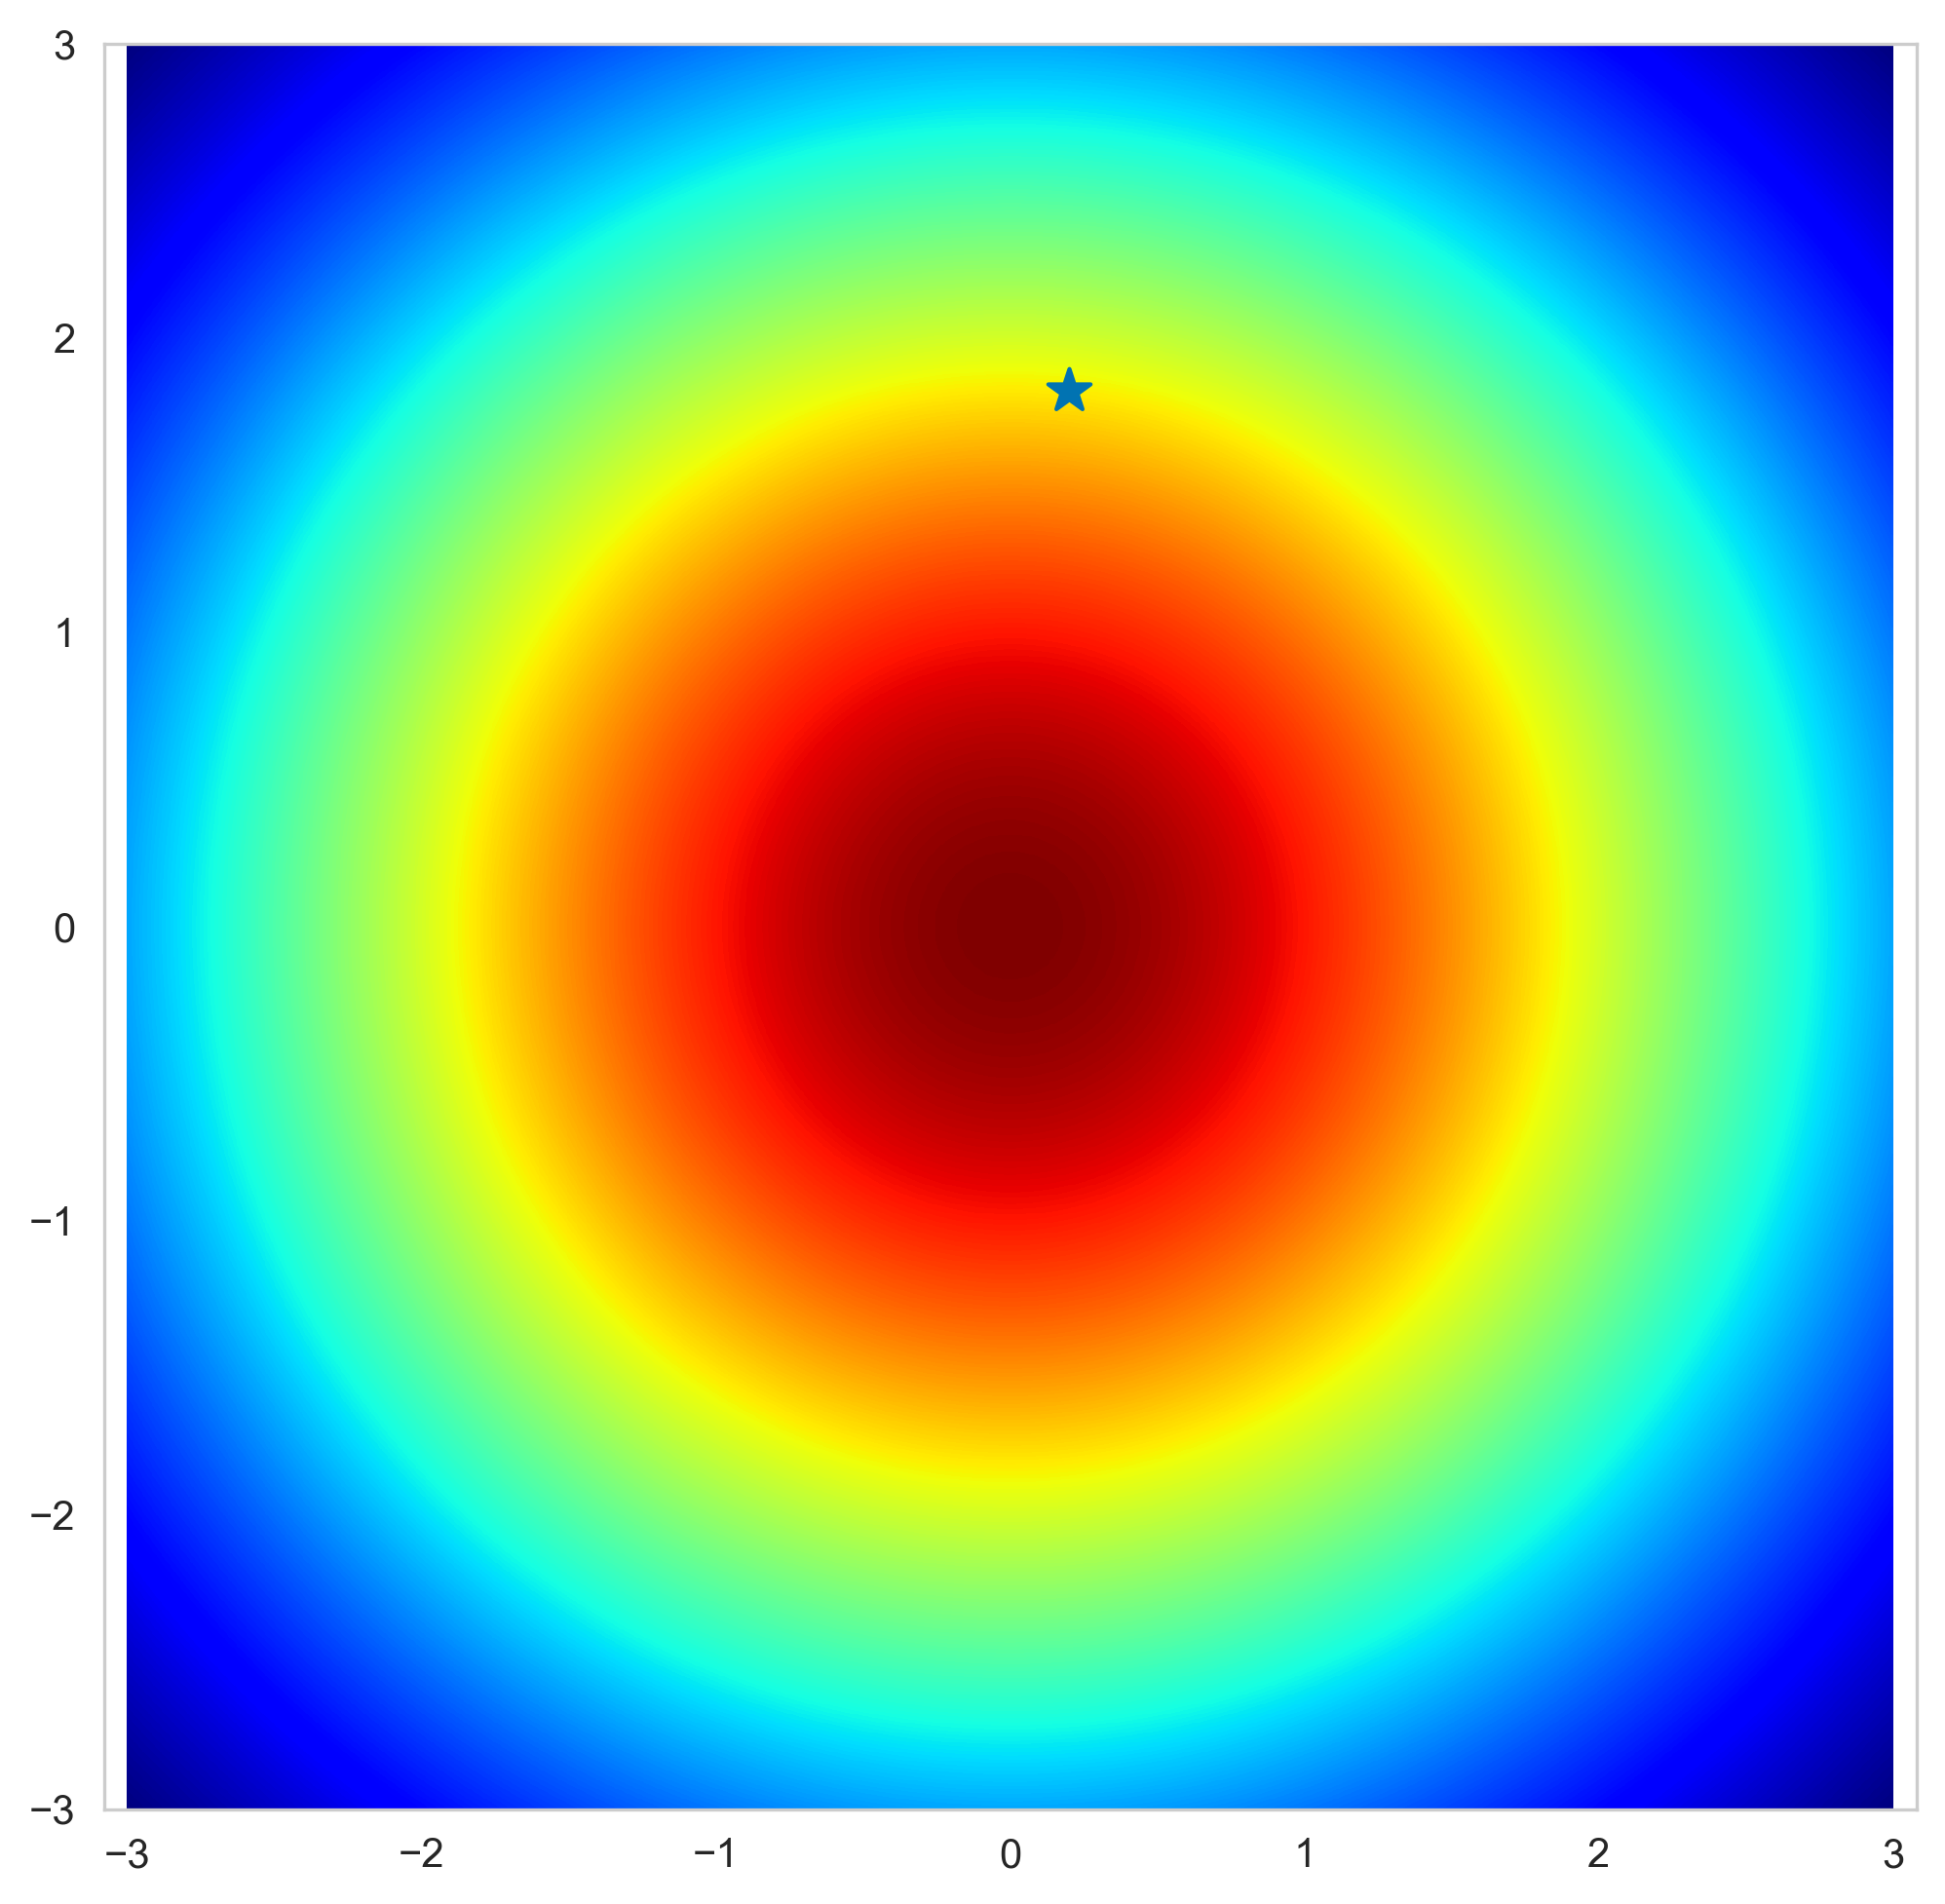

In [211]:
cur_mu, cur_sigma = np.array([0, 0]), 5 * np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((-3, 3))
ax.set_ylim((-3, 3))
myplot_heatmap(Z)

In [212]:
noise = np.std(np.log(train['total_cases']) - predicted_train)

In [213]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.hstack((x,np.ones((len(x), 1))))
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * (np.transpose(x_matrix) @ x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y ) )
    return mu_n, sigma_n

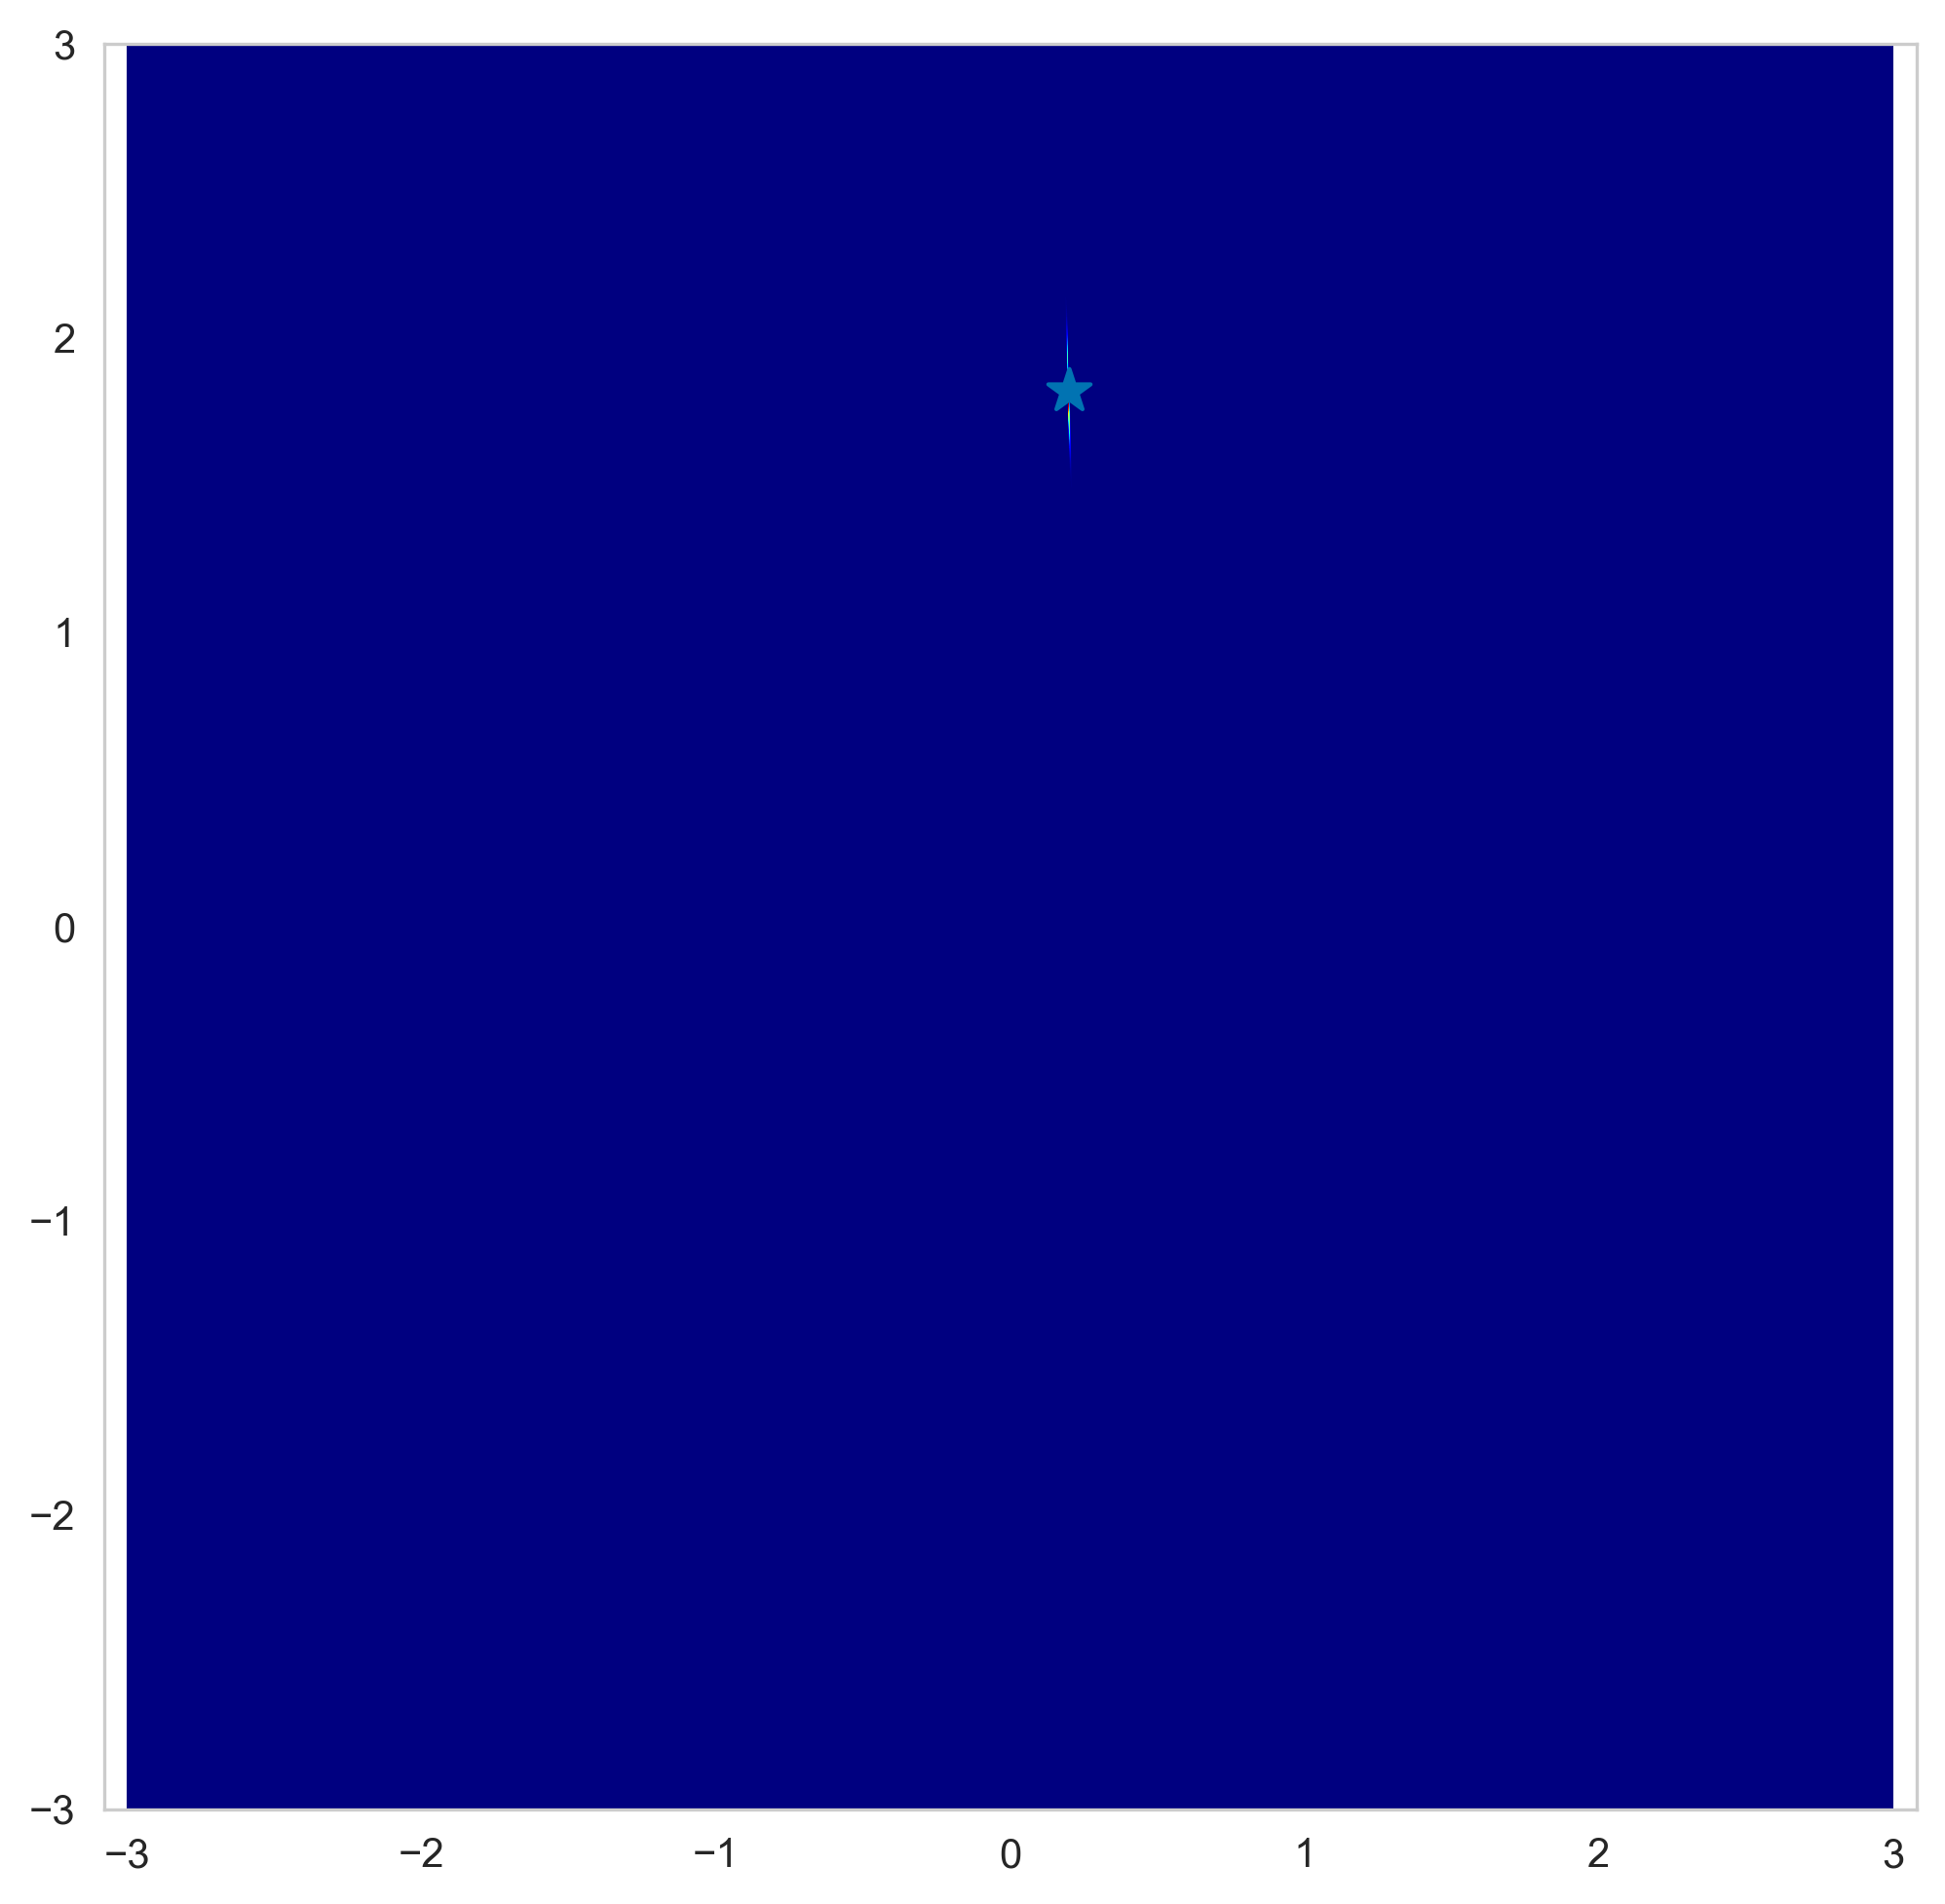

In [214]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X_train, y_train, sigma_noise=noise)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_heatmap(Z)

In [236]:
cur_mu

array([0.19839464, 1.81731025])

### 2.c. Сэмплирование ###

In [260]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    # plt.axis('equal')
    for w in my_w:
        plt.plot(X_train, np.exp(w[1] + w[0]*X_train), 'k-', lw=.4)
    #plt.ylim((0, 70000))
    #plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
        
    return my_w

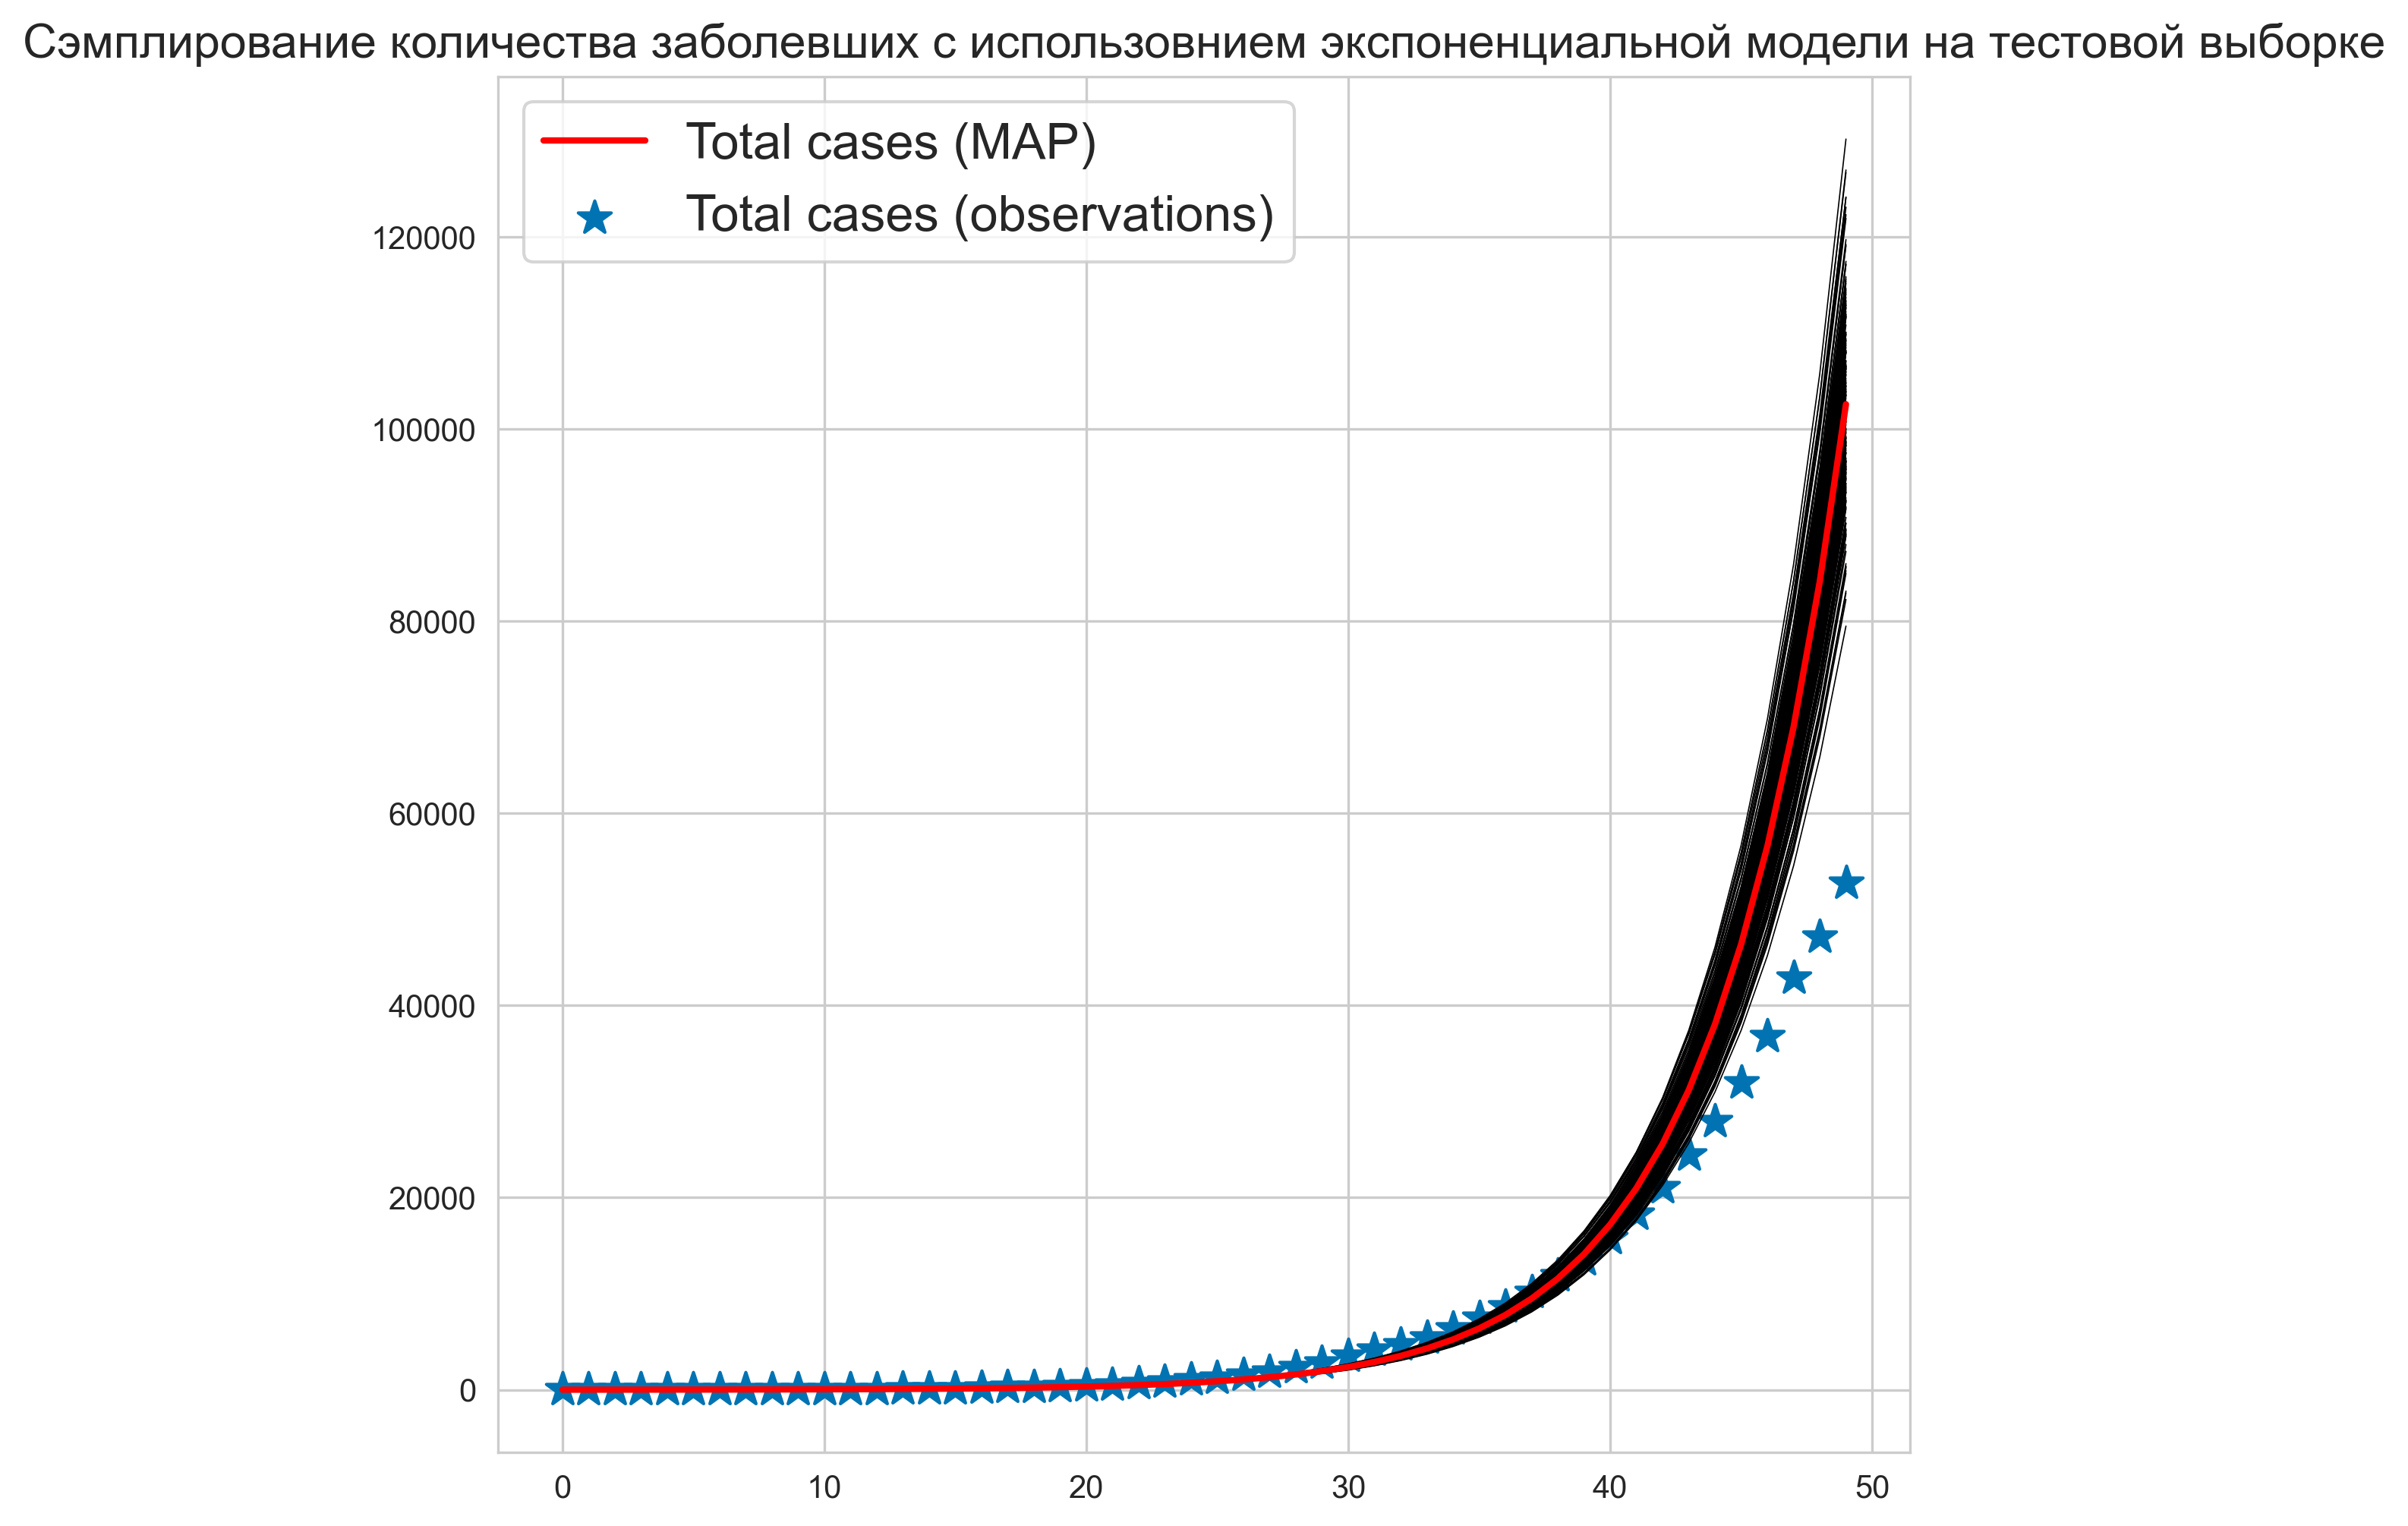

In [265]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
#ax.set_xlim((xs[0], xs[-1]))
#ax.set_ylim((-2, 2))
samples = myplot_sample_lines(cur_mu, cur_sigma, N_SAMPLES)
ax.scatter(X_train, np.exp(y_train), marker='*', s=120, label='Total cases (observations)')
ax.plot(X_train, np.exp(X_train * cur_mu[0] + cur_mu[1]), color="red", label='Total cases (MAP)', lw=2.0)
ax.set_title('Сэмплирование количества заболевших с использовнием экспоненциальной модели на тестовой выборке', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

In [295]:
raw_dates = ['2020-05-01', '2020-06-01', '2020-09-01']
days = [(dt.datetime.strptime(x,'%Y-%m-%d') - START_DATE).days for x in raw_dates]
real_data = [df_russia[(df_russia['day'] == day)]['total_cases'] for day in days]

In [270]:
sample_prediction = np.zeros((len(days), N_SAMPLES))
for day in range(len(days)):
    sample_prediction[day] =  np.exp(samples[:,1] + samples[:,0]*days[day])

In [308]:
for i in range(len(days)):
    print(f"{raw_dates[i]} : Реальное количество {int(df_russia[(df_russia['day'] == days[i])]['total_cases'].values[0])} Ср по сэмплам {int(np.mean(sample_prediction[i]))} Ст. отклонение {int(np.std(sample_prediction[i]))}")

2020-05-01 : Реальное количество 114431 Ср по сэмплам 740656 Ст. отклонение 91119
2020-06-01 : Реальное количество 414328 Ср по сэмплам 347036057 Ст. отклонение 77713502
2020-09-01 : Реальное количество 997072 Ср по сэмплам 31166724466667412 Ст. отклонение 17823915442040214


## 3. Сигмоидная модель ##

### 3.a. Параметризация ###

Функция распределения 


$Ф(x) = \frac{1}{\sqrt{2 \pi}} \int_{-\inf}^{x} e^{-\frac{t^2}{2}}dt$

где $t = w_2z^2 + w_1z + w_0$

Тогда плотность вероятности

$pdf(x) = e^{w_2x^2 + w_1x + w_0}$

Тогда ее логарифм

$ln(pdf(x)) = w_2x^2 + w_1x + w_0$ 

что является линейной комбинацией, а значит может быть апроксимирована линейной регрессией

### 3.b. Обучение сигмоидной модели ###

In [329]:
x0 = np.ones(len(train['day']))
x1 = np.array(train['day'])
x2 = x1 ** 2
X_train_sigmoid = np.transpose(np.stack((x0,x1,x2)))
#X_train_sigmoid = np.stack(np.ones(len(train['day'])), np.array(train['day']), np.array(train['day']) ** 2)

In [334]:
y_train_sigmoid = np.array(np.log(train['new_cases']))

In [378]:
lr_model_sigmoid = linear_model.LinearRegression(fit_intercept=False)

lr_model_sigmoid.fit(X_train_sigmoid, y_train_sigmoid)
lr_model_sigmoid.score(X_train_sigmoid, y_train_sigmoid), lr_model.coef_[0], lr_model.intercept_

(0.9683360173111185, 0.19829091233588558, 1.8207371487846977)

In [379]:
predicted_train_sigmoid = lr_model_sigmoid.predict(X_train_sigmoid)
predicted_train_total_sigmoid = np.cumsum(np.exp(predicted_train_sigmoid))

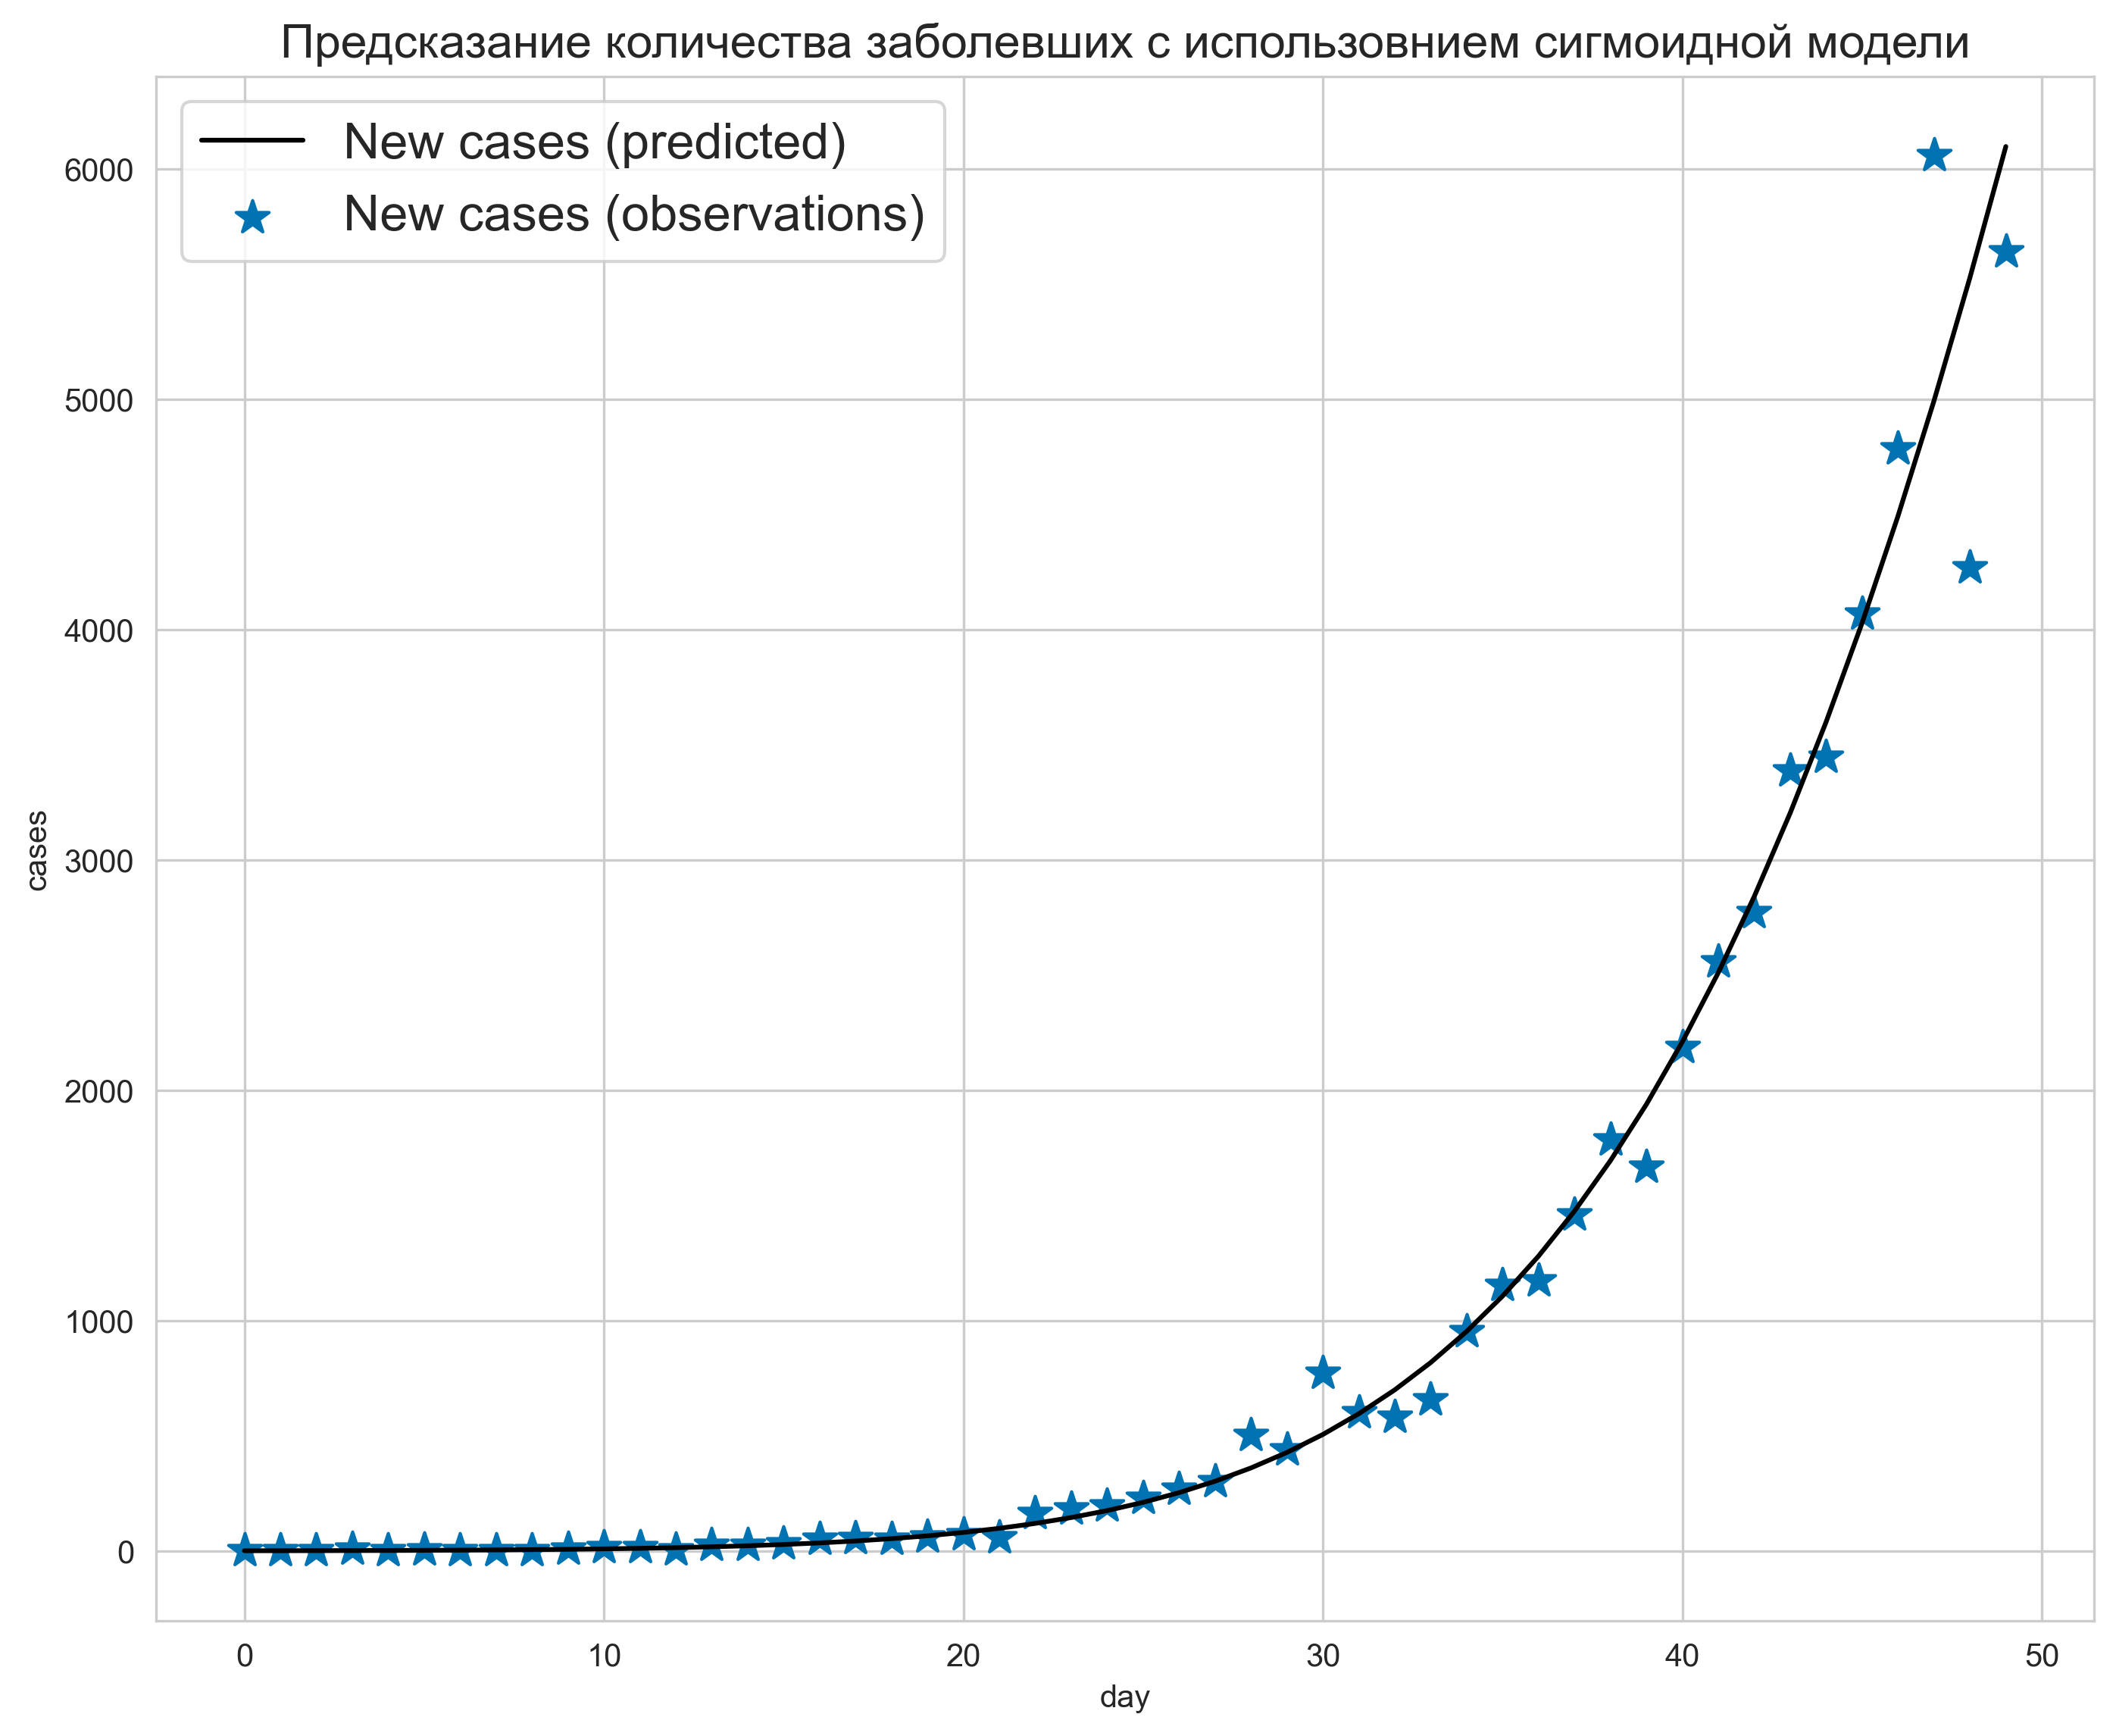

In [380]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.scatter(train['day'], train['new_cases'], label='New cases (observations)', marker='*', s=120)
ax.plot(train['day'], np.exp(predicted_train_sigmoid), label='New cases (predicted)', color='black')
ax.set_ylabel('cases')
ax.set_xlabel('day')
ax.set_title('Предсказание количества заболевших с использовнием сигмоидной модели', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

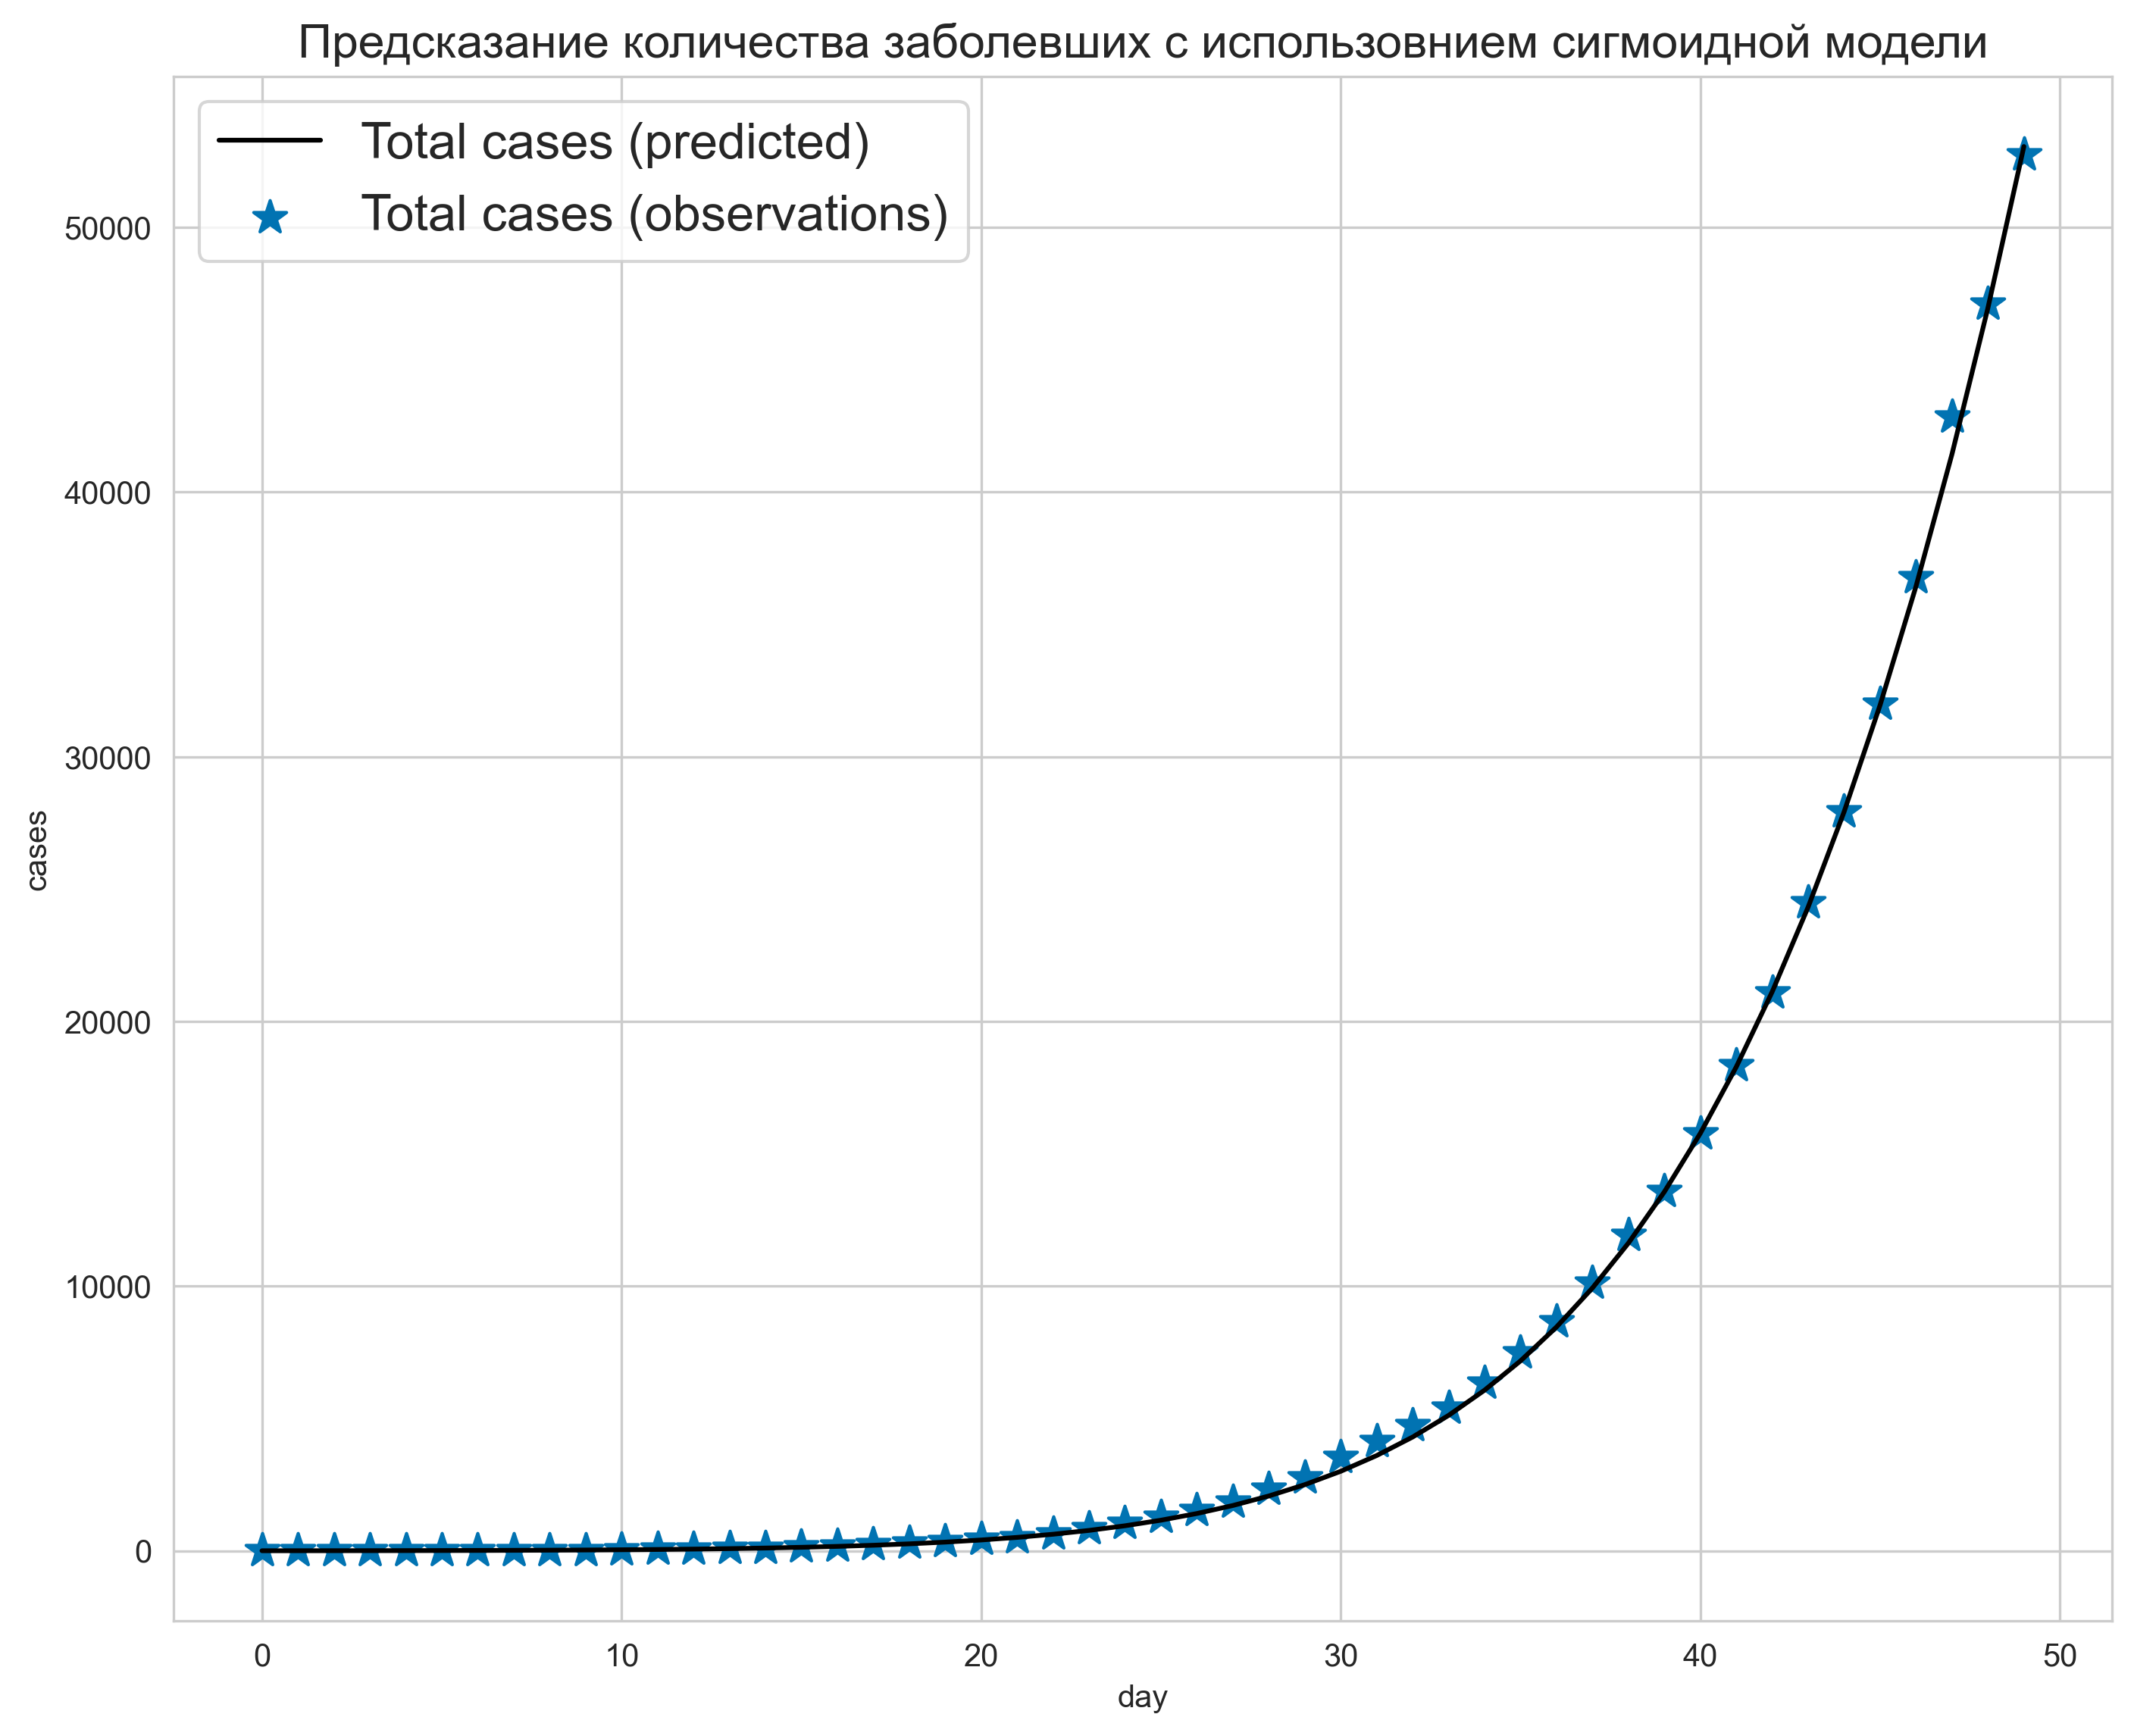

In [381]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.scatter(train['day'], train['total_cases'], label='Total cases (observations)', marker='*', s=120)
ax.plot(train['day'],predicted_train_total_sigmoid, label='Total cases (predicted)', color='black')
ax.set_ylabel('cases')
ax.set_xlabel('day')
ax.set_title('Предсказание количества заболевших с использовнием сигмоидной модели', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

In [382]:
x0 = np.ones(len(df_russia['day']))
x1 = np.array(df_russia['day'])
x2 = x1 ** 2
X_all_sigmoid = np.transpose(np.stack((x0,x1,x2)))

In [383]:
predicted_all_sigmoid = lr_model_sigmoid.predict(X_all_sigmoid)
predicted_all_total_sigmoid = np.cumsum(np.exp(predicted_all_sigmoid))

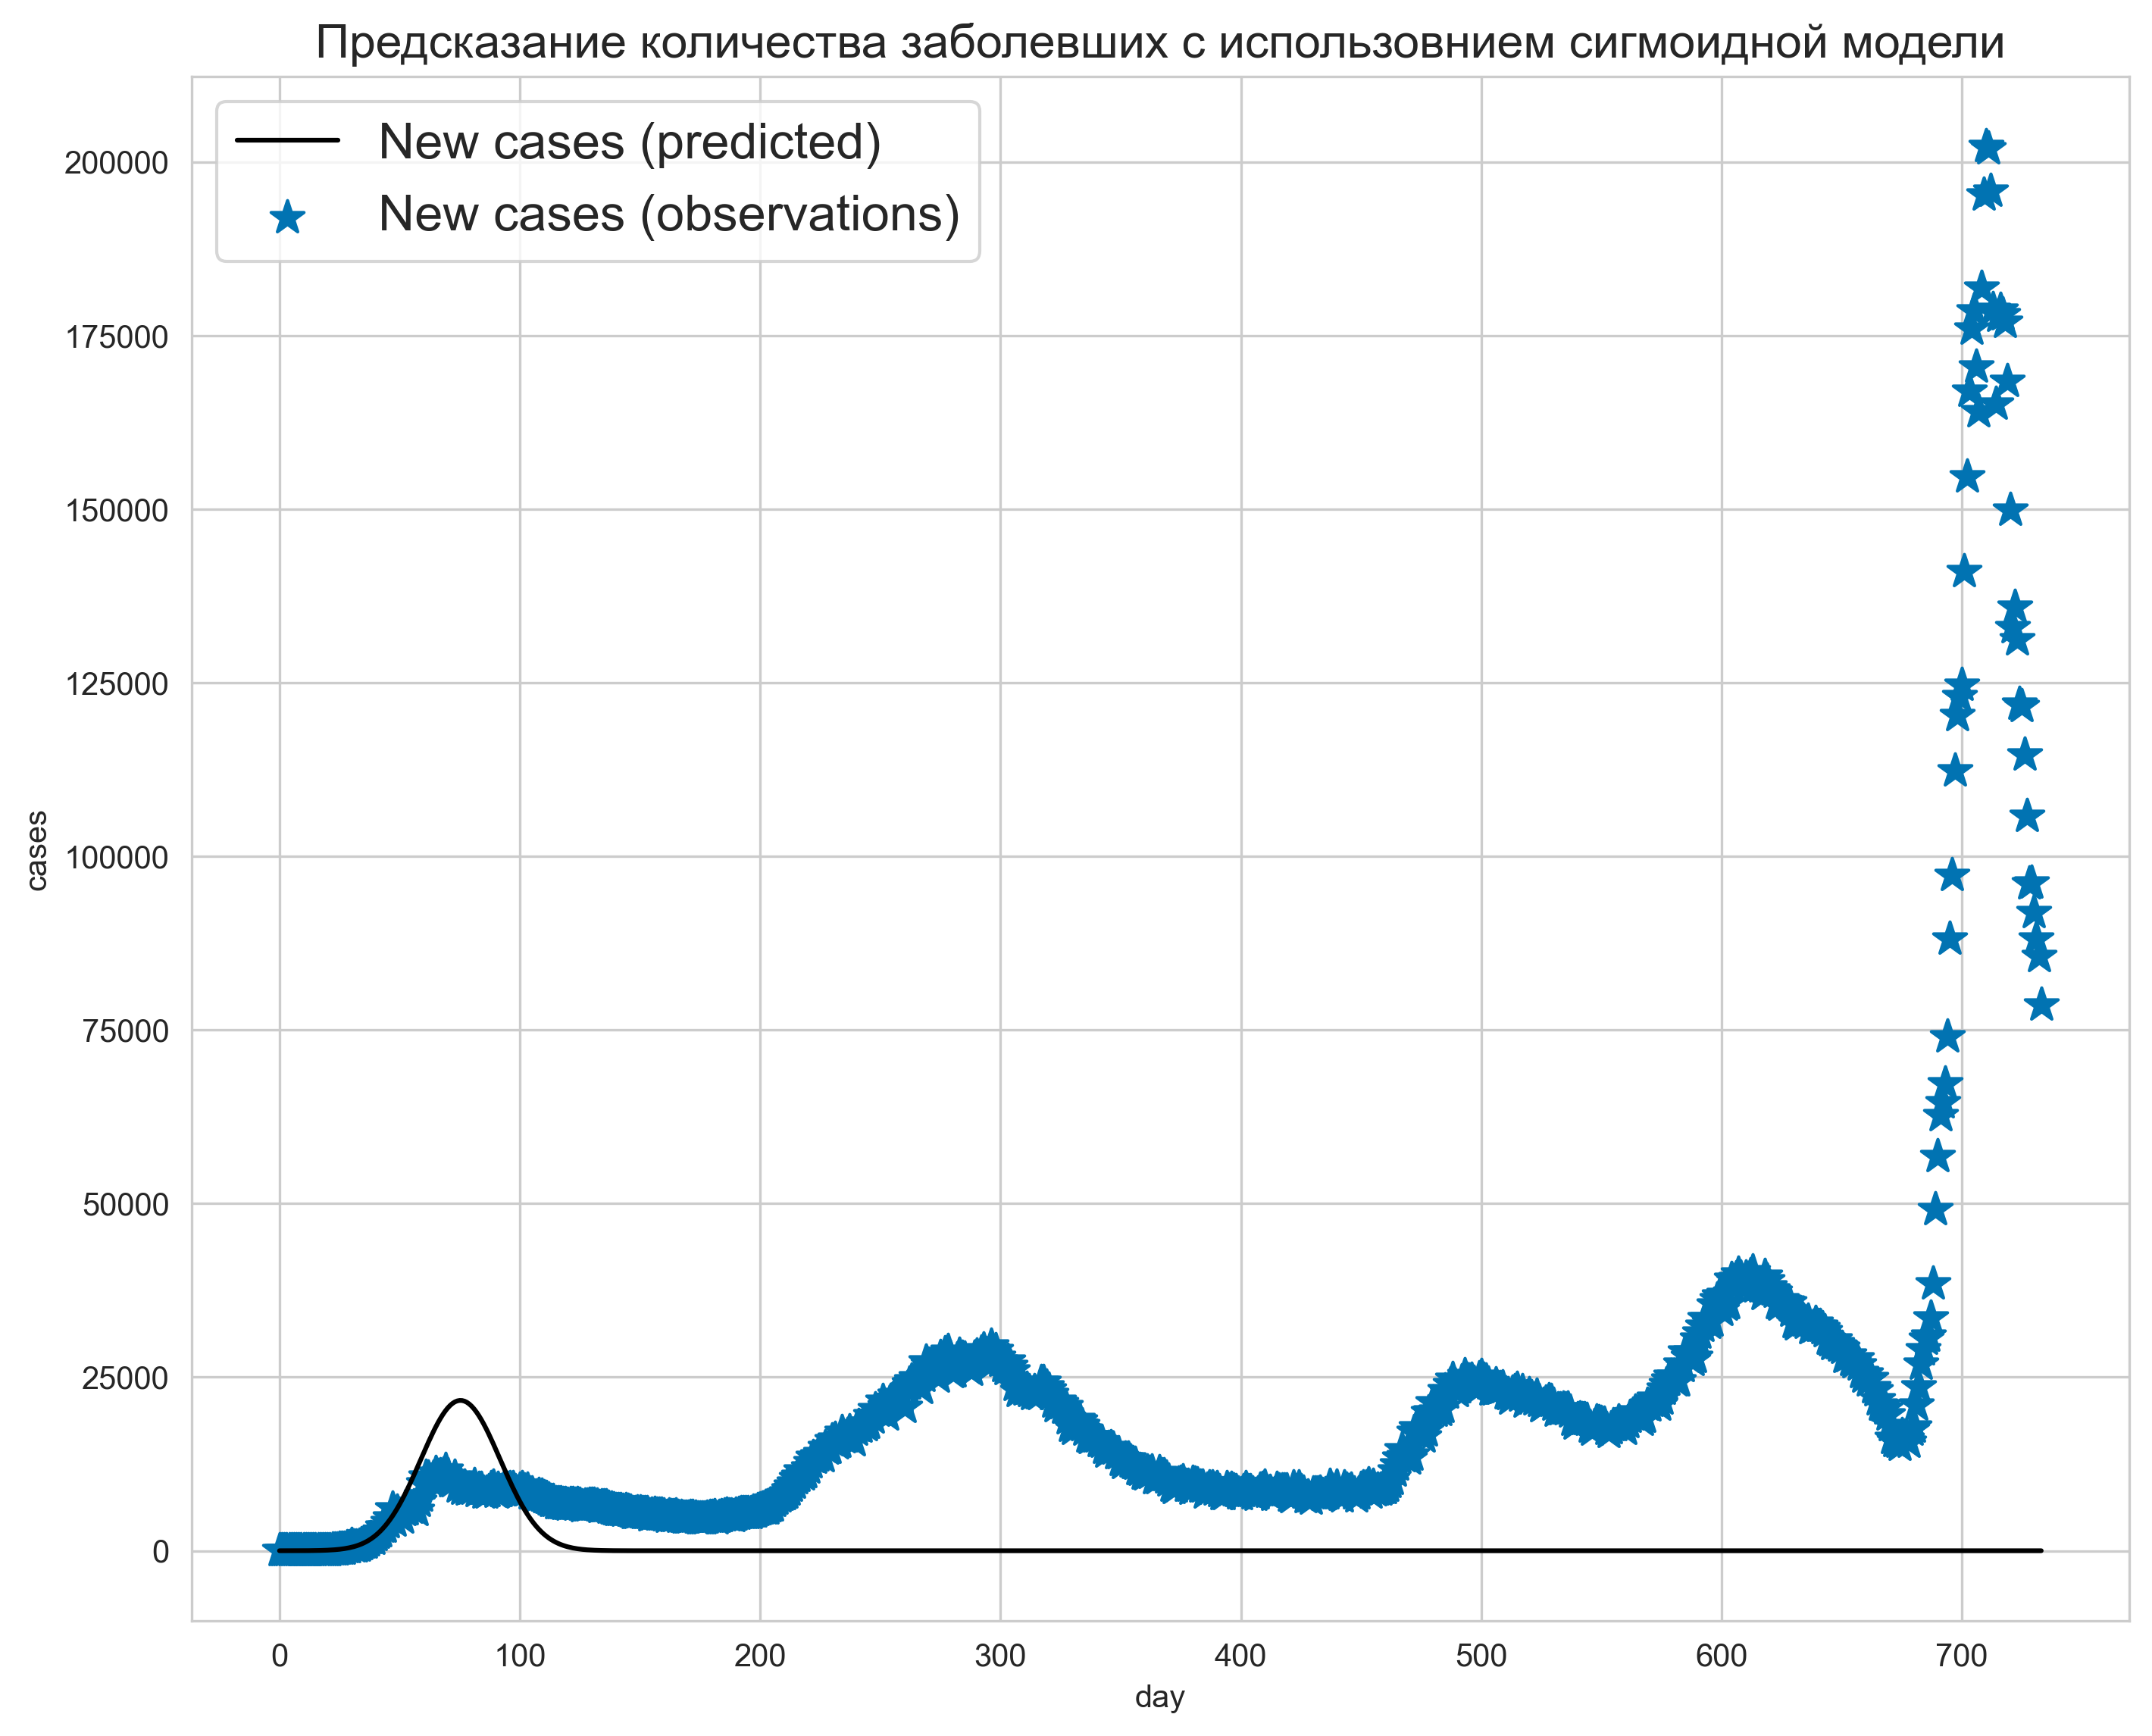

In [384]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.scatter(df_russia['day'], df_russia['new_cases'], label='New cases (observations)', marker='*', s=120)
ax.plot(df_russia['day'], np.exp(predicted_all_sigmoid), label='New cases (predicted)', color='black')
ax.set_ylabel('cases')
ax.set_xlabel('day')
ax.set_title('Предсказание количества заболевших с использовнием сигмоидной модели', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

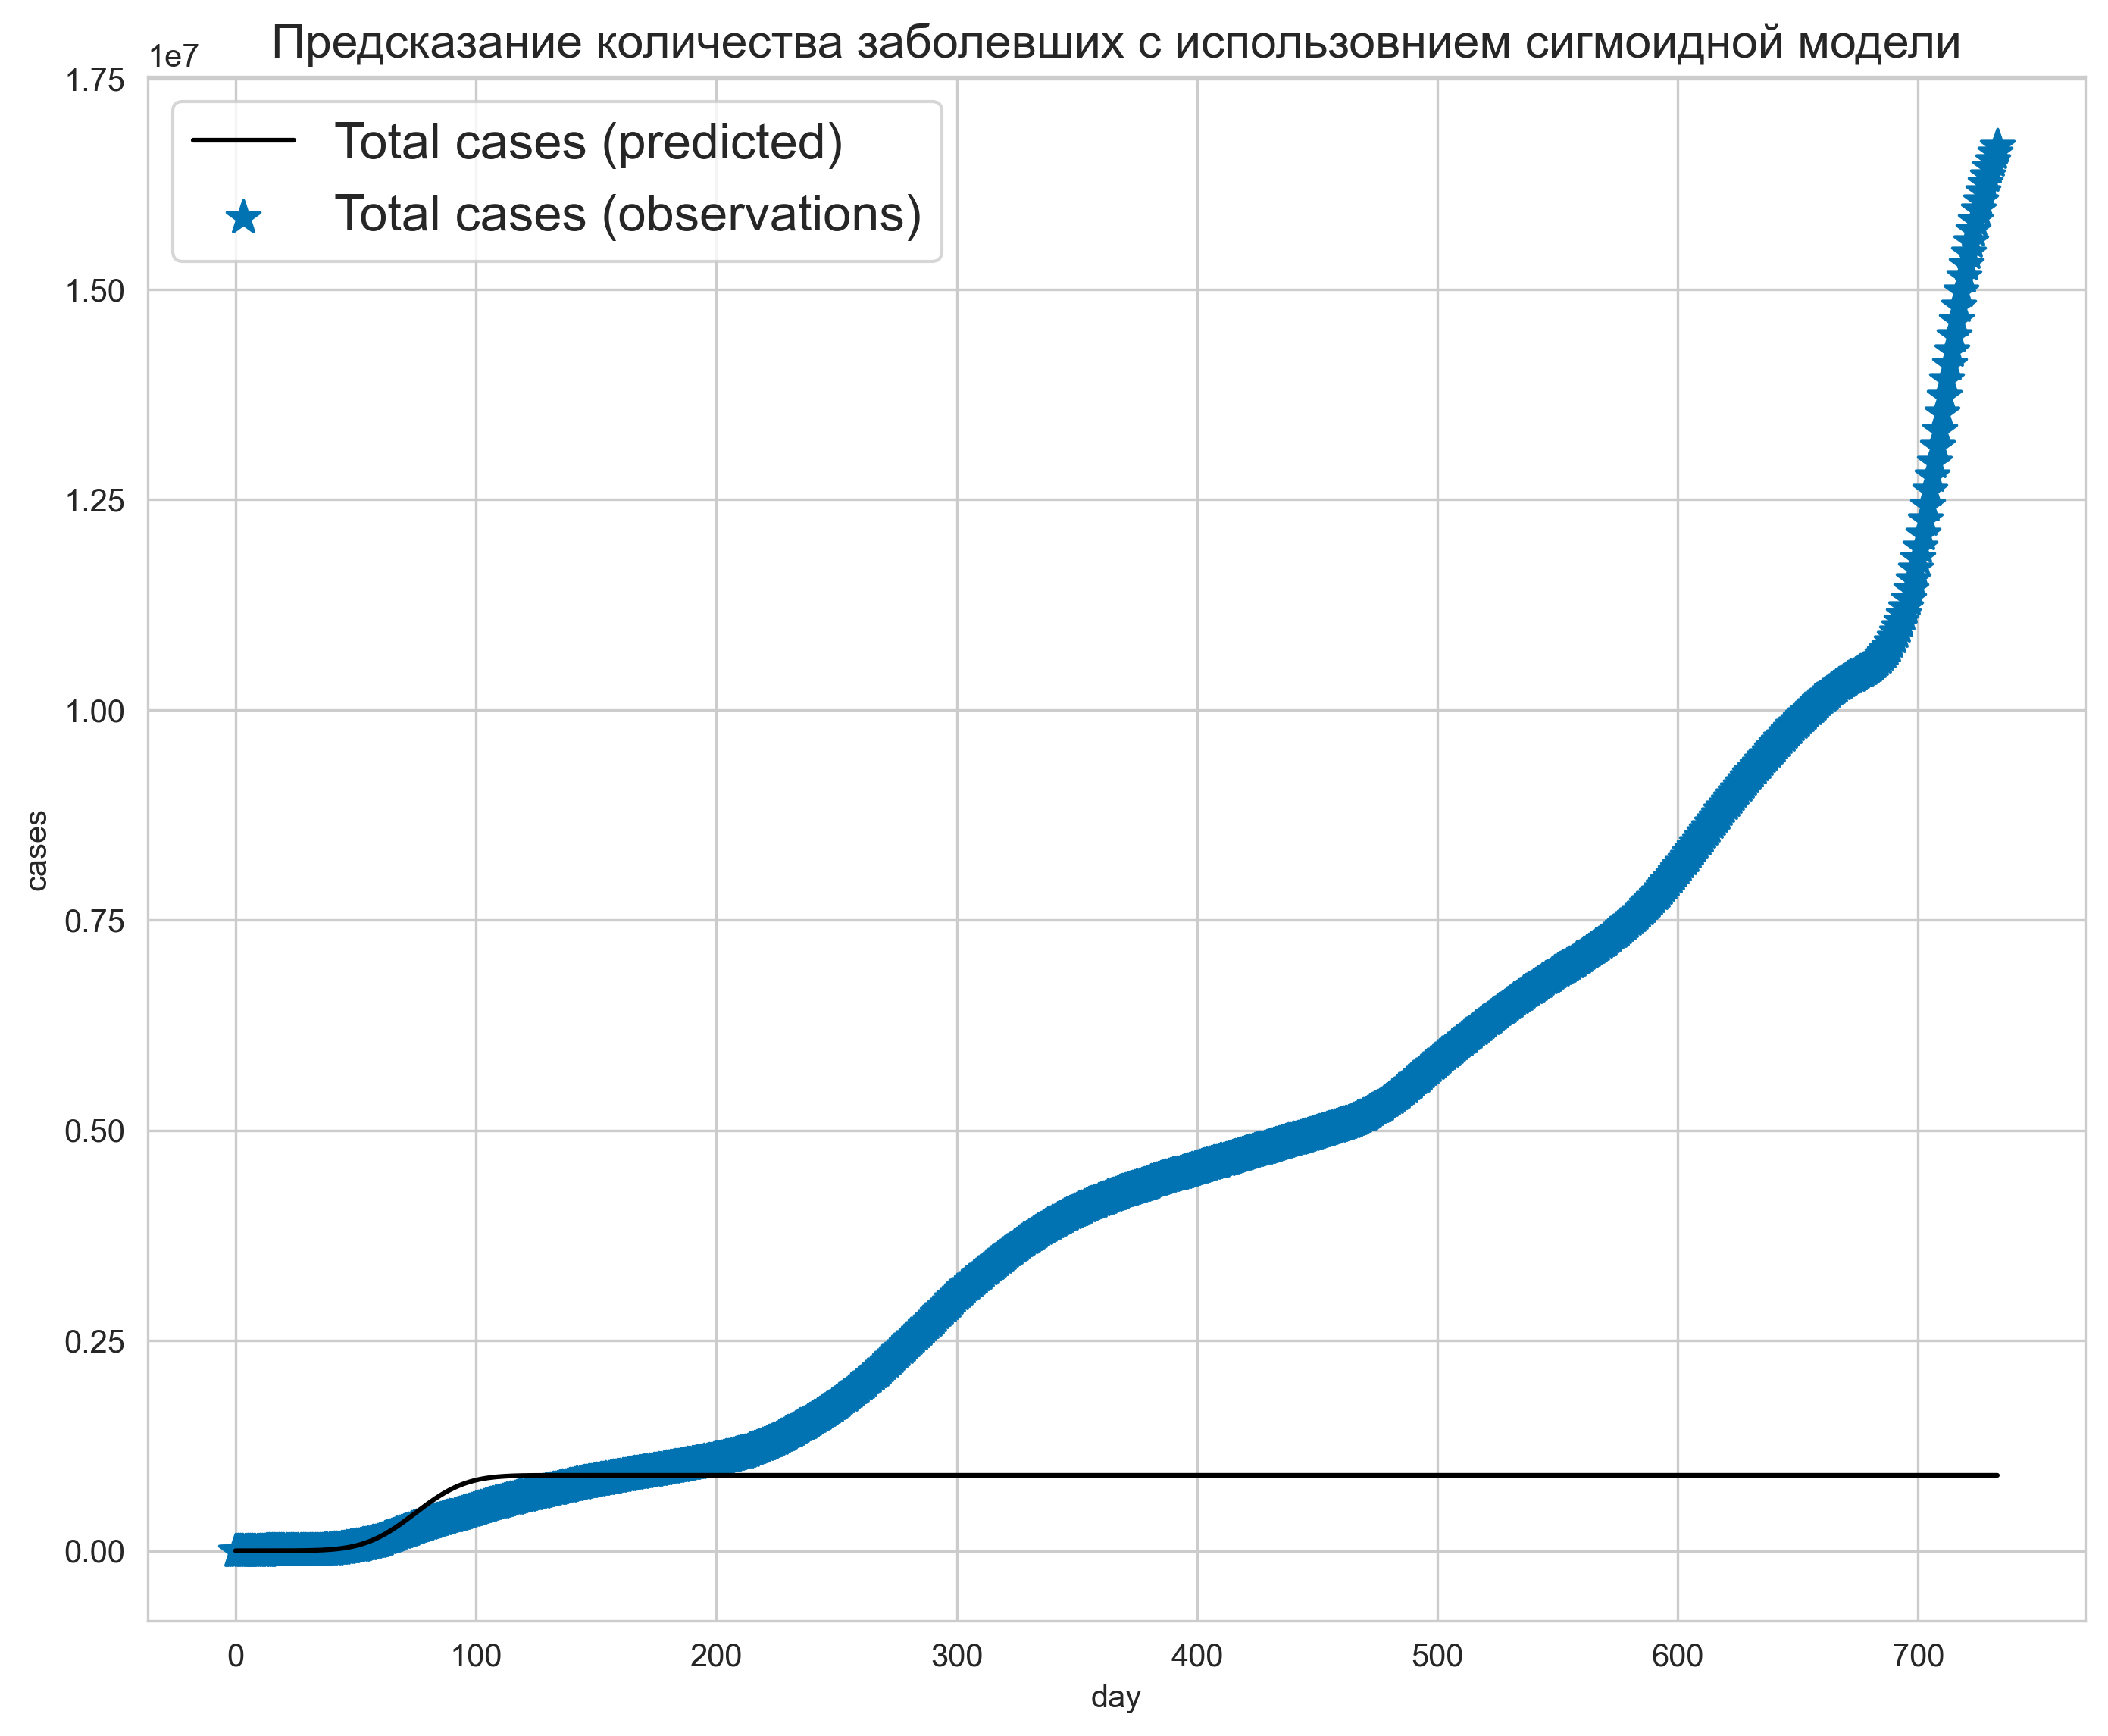

In [385]:
ig, ax = plt.subplots(figsize=(11, 9))
ax.scatter(df_russia['day'], df_russia['total_cases'], label='Total cases (observations)', marker='*', s=120)
ax.plot(df_russia['day'],predicted_all_total_sigmoid, label='Total cases (predicted)', color='black')
ax.set_ylabel('cases')
ax.set_xlabel('day')
ax.set_title('Предсказание количества заболевших с использовнием сигмоидной модели', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

In [386]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    #x_matrix = np.hstack((x,np.ones((len(x), 1))))
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * (np.transpose(x_matrix) @ x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y ) )
    return mu_n, sigma_n

In [387]:
cur_mu, cur_sigma = [0, 0, 0], 200 * np.eye(3, 3)

noise_sigmoid = np.std(y_train_sigmoid - lr_model_sigmoid.predict(X_train_sigmoid))
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X_train_sigmoid, y_train_sigmoid, sigma_noise=noise_sigmoid)

In [388]:
cur_mu

array([-0.39650706,  0.27561597, -0.00182967])

In [390]:
lr_model_sigmoid.coef_

array([-0.3965904 ,  0.27562283, -0.00182979])

### 3.c. Сэмплирование ###

In [449]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    # plt.axis('equal')
    for w in my_w:
        plt.plot(train['day'], np.cumsum(np.exp(X_train_sigmoid @ w)), 'k-', lw=.4)
    #plt.ylim((0, 70000))
    #plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
        
    return my_w

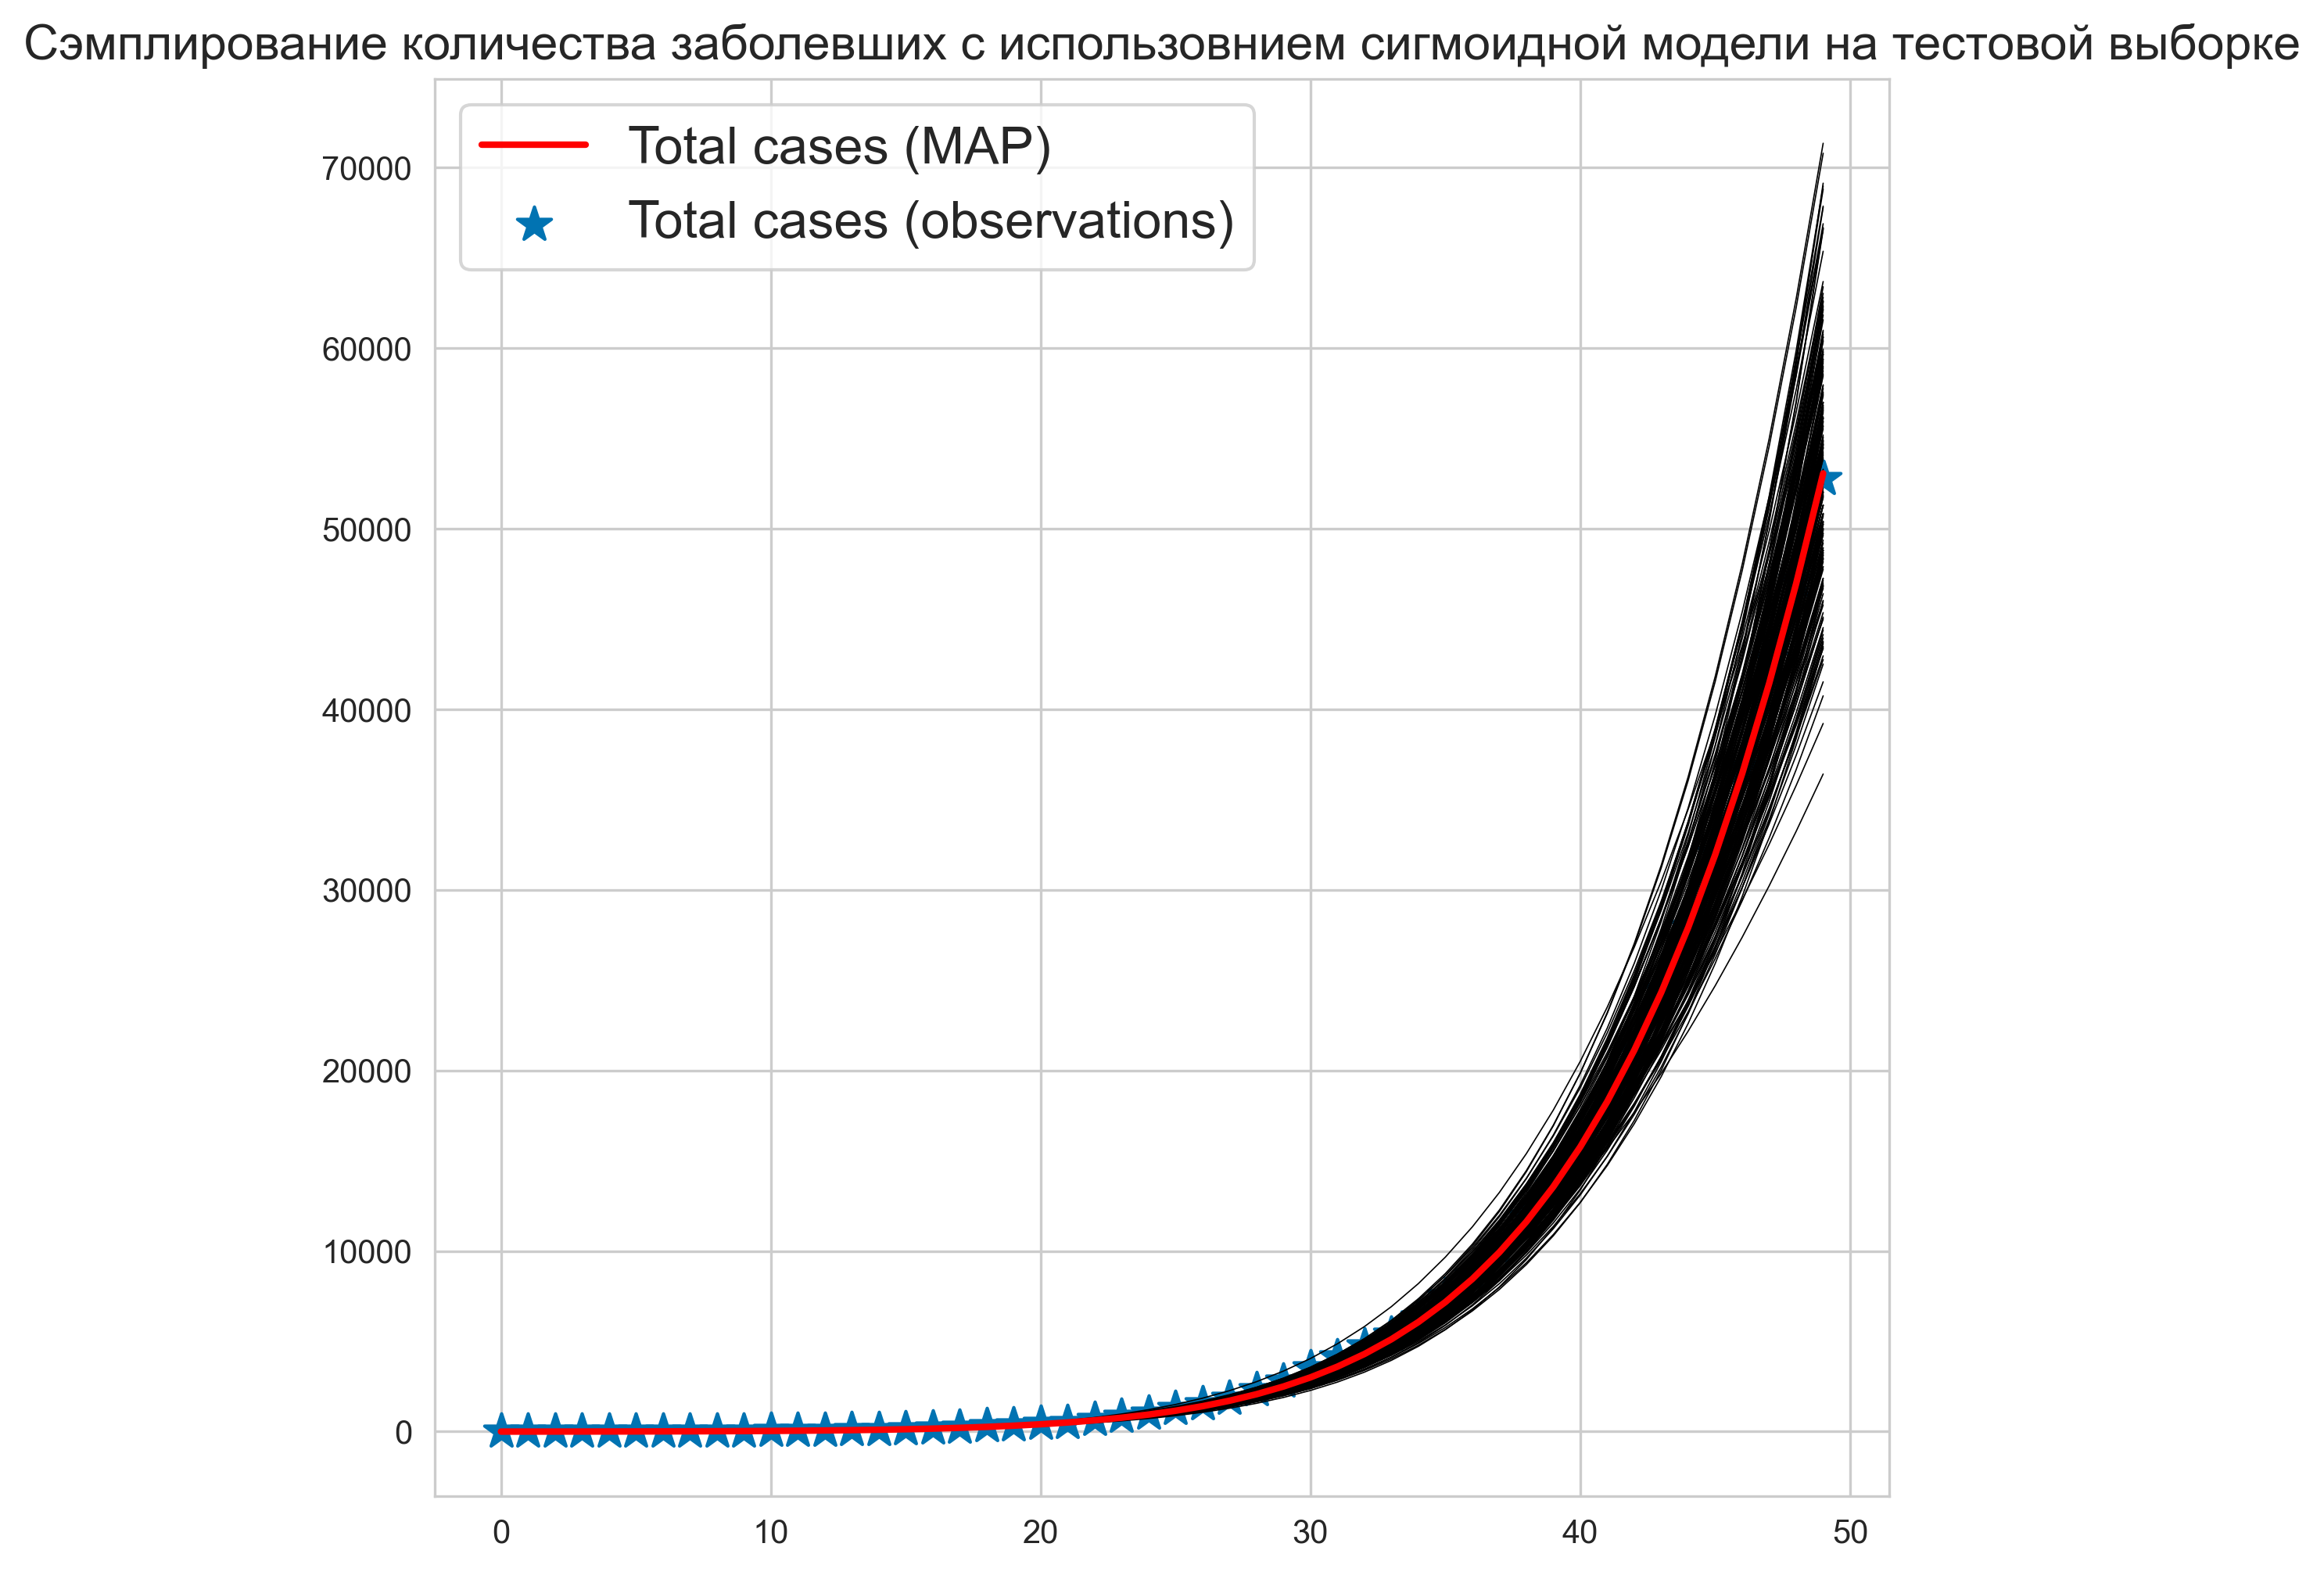

In [450]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
#ax.set_xlim((xs[0], xs[-1]))
#ax.set_ylim((-2, 2))
samples = myplot_sample_lines(cur_mu, cur_sigma, N_SAMPLES)
ax.scatter(train['day'], train['total_cases'], marker='*', s=120, label='Total cases (observations)')
ax.plot(train['day'], np.cumsum(np.exp(X_train_sigmoid @ cur_mu)), color="red", label='Total cases (MAP)', lw=2.0)
ax.set_title('Сэмплирование количества заболевших с использовнием сигмоидной модели на тестовой выборке', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

In [451]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    # plt.axis('equal')
    for w in my_w:
        plt.plot(df_russia['day'], np.cumsum(np.exp(X_all_sigmoid @ w)), 'k-', lw=.4)
    plt.ylim((0, 20000000))
    #plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
        
    return my_w

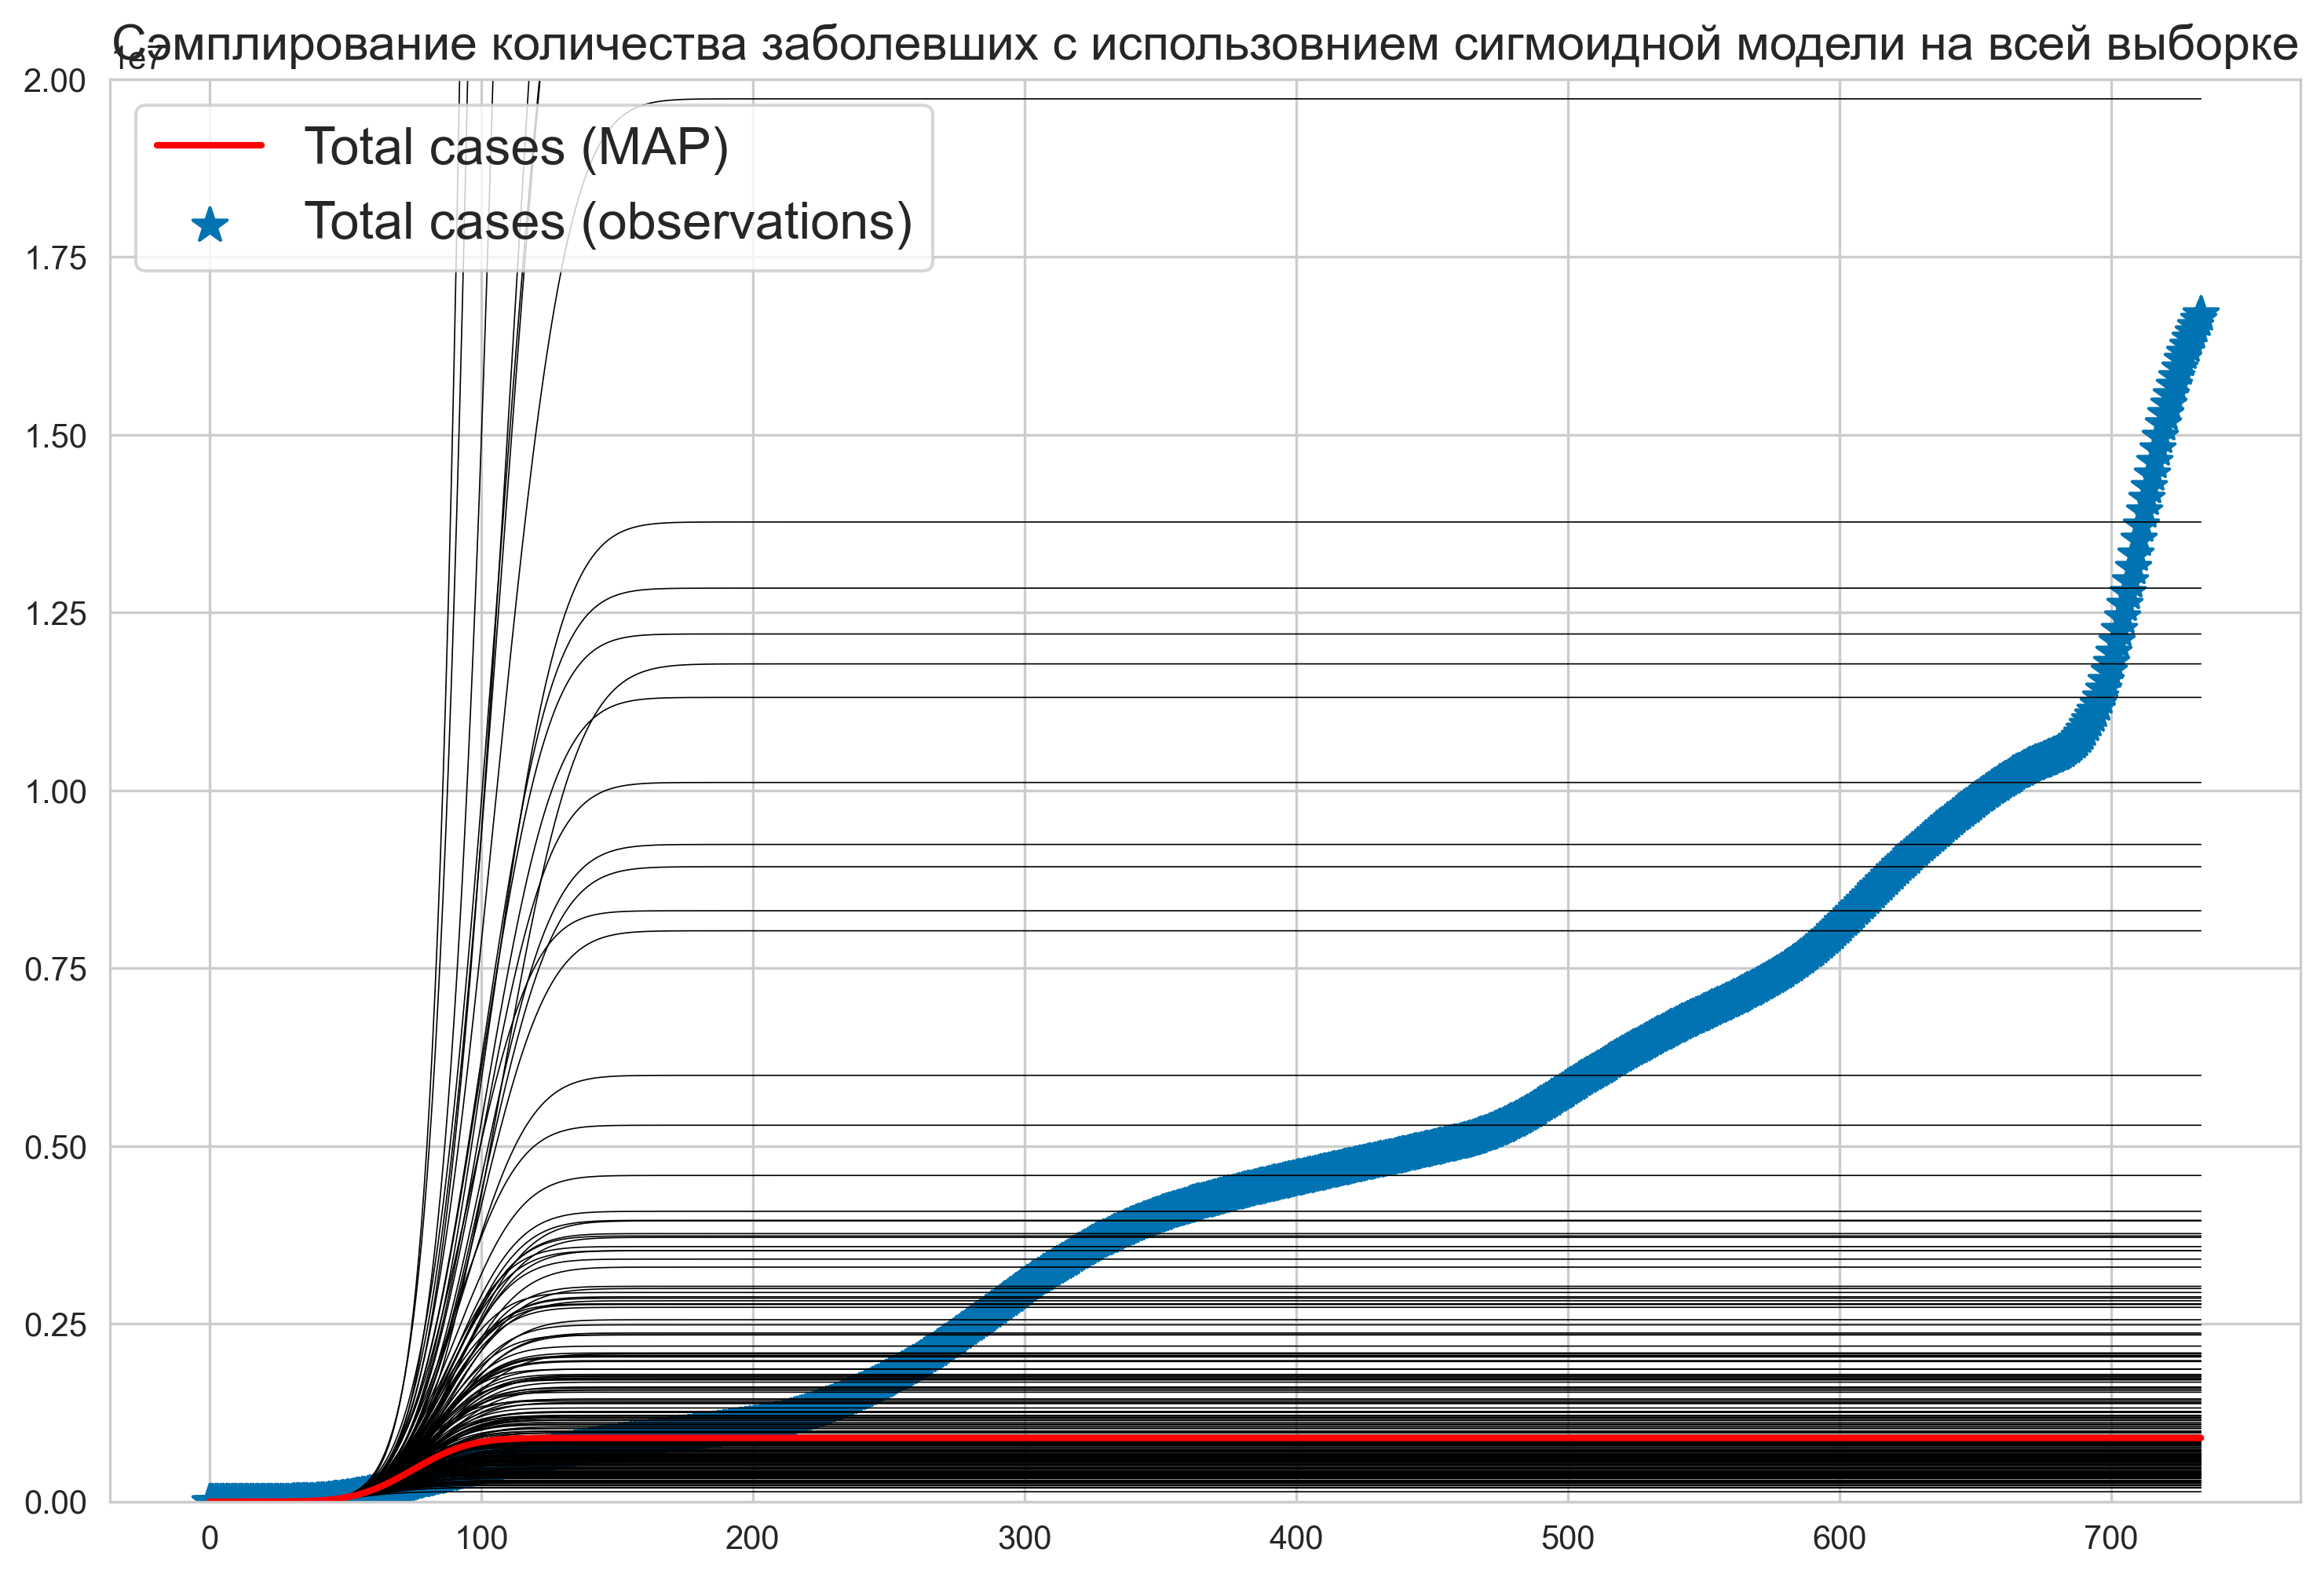

In [452]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
#ax.set_xlim((xs[0], xs[-1]))
#ax.set_ylim((-2, 2))
samples_all = myplot_sample_lines(cur_mu, cur_sigma, N_SAMPLES)
ax.scatter(df_russia['day'], df_russia['total_cases'], marker='*', s=120, label='Total cases (observations)')
ax.plot(df_russia['day'], np.cumsum(np.exp(X_all_sigmoid @ cur_mu)), color="red", label='Total cases (MAP)', lw=2.0)
ax.set_title('Сэмплирование количества заболевших с использовнием сигмоидной модели на всей выборке', fontsize=15)
ax.legend(loc="upper left", fontsize=legend_fontsize)

In [453]:
x0 = np.ones(len(days))
x1 = np.array(days)
x2 = x1 ** 2
days_sigmoid = np.transpose(np.stack((x0,x1,x2)))

sample_prediction = np.zeros((len(days), N_SAMPLES))
for day in range(len(days)):    
    sample_prediction[day] =  np.cumsum(np.exp(samples @ days_sigmoid[day])) #np.exp(samples[:,1] + samples[:,0]*days[day])

In [454]:
for i in range(len(days)):
    print(f"{raw_dates[i]} : Реальное количество {int(df_russia[(df_russia['day'] == days[i])]['total_cases'].values[0])} Ср по сэмплам {int(np.mean(sample_prediction[i]))} Ст. отклонение {int(np.std(sample_prediction[i]))}")

2020-05-01 : Реальное количество 114431 Ср по сэмплам 1471119 Ст. отклонение 840007
2020-06-01 : Реальное количество 414328 Ср по сэмплам 5546155 Ст. отклонение 3068482
2020-09-01 : Реальное количество 997072 Ср по сэмплам 5805138 Ст. отклонение 1596593


In [455]:
for i in range(len(days)):
    print(f"{raw_dates[i]} : Реальное количество {int(df_russia[(df_russia['day'] == days[i])]['total_cases'].values[0])}; 10персентиль {int(np.percentile(sample_prediction[i],10))}; 90персентиль {int(np.percentile(sample_prediction[i],90))}")

2020-05-01 : Реальное количество 114431; 10персентиль 331506; 90персентиль 2642379
2020-06-01 : Реальное количество 414328; 10персентиль 1885570; 90персентиль 9891995
2020-09-01 : Реальное количество 997072; 10персентиль 6049568; 90персентиль 6438508


## 4. Бонусеая часть ##

К сожалению, не успел ничего сделать

## 5. Выводы ##

Задание помогло понять механику байесовского вывода